Q2

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

In [42]:
# Load the dataset
data_path = './datasets/regression_data_multiGen_group_12_train.txt'

# Adjusting the data loading process to skip the header row
data = np.loadtxt(data_path, skiprows=1)
np.random.seed(42)  # For reproducibility
np.random.shuffle(data)  # Randomly shuffle the data

# Separate features and targets again
X = data[:, :2]  # Features (sensor readings)
y = data[:, 2:]  # Targets (y1, y2, y3 positions)

split_idx1 = int(X.shape[0] * 0.6)
split_idx2 = split_idx1 + int((X.shape[0] - split_idx1) * 0.5)

X_train = X[:split_idx1]
X_val = X[split_idx1:split_idx2]
X_test = X[split_idx2:]
y_train = y[:split_idx1]
y_val = y[split_idx1:split_idx2]
y_test = y[split_idx2:]

mean_X = np.mean(X_train, axis=0)
std_dev_X = np.std(X_train, axis=0)
norm2_X = np.linalg.norm(X_train, axis=0)

mean_y = np.mean(y_train, axis=0)
std_dev_y = np.std(y_train, axis=0)
norm2_y = np.linalg.norm(y_train, axis=0)

X_train_norm_2 = X_train / norm2_X
y_train_norm_2 = y_train / norm2_y

X_val_norm_2 = X_val / norm2_X
y_val_norm_2 = y_val / norm2_y

X_test_norm_2 = X_test / norm2_X
y_test_norm_2 = y_test / norm2_y

X_train_norm_zs = (X_train - mean_X) / std_dev_X
y_train_norm_zs = (y_train - mean_y) / std_dev_y

X_val_norm_zs = (X_val - mean_X) / std_dev_X
y_val_norm_zs = (y_val - mean_y) / std_dev_y

X_test_norm_zs = (X_test - mean_X) / std_dev_X
y_test_norm_zs = (y_test - mean_y) / std_dev_y

def phin_x(X, n):
    X_poly = np.empty((X.shape[0], X.shape[1]*n))
    for i in range(X.shape[1]):
        X_i = X[:, i]
        X_poly[:, i*n:i*n+n] = np.array([X_i**j for j in range(n, 0, -1)]).T
    return np.c_[X_poly, np.ones((X.shape[0], 1))]

In [43]:
def get_theta_poly(X, y, n):
    # Add a bias term (column of ones) to X for the intercept
    X_b = phin_x(X, n)

    # Solve the normal equation again: theta = (X_b.T * X_b)^(-1) * X_b.T * y
    theta = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

    return theta


In [44]:
def print_poly(theta, d=1, norm=""):
    m, n = theta.shape
    norm = "_"+norm if norm != "" else ""
    for i in range(n):
        poly = ""
        for j in range((m-1)//d):
            for k in range(d):
                poly += f"{theta[j*k+k][i]:.4f}*X{j+1}^{d-k}{norm} + "
        print(poly + f"{theta[j][i]:.4f} = y{i+1}{norm}'")

In [45]:
# Calculating the Pearson Correlation, MSE, and MAE using only numpy

# Function to calculate Pearson Correlation Coefficient
def pearson_correlation(actual, predicted):
    numerator = np.sum((actual - np.mean(actual)) *
                       (predicted - np.mean(predicted)))
    denominator = np.sqrt(np.sum((actual - np.mean(actual))**2)
                          * np.sum((predicted - np.mean(predicted))**2))
    return numerator / denominator

# Function to calculate Mean Squared Error
def root_mean_squared_error(actual, predicted):
    return np.sqrt(np.mean((actual - predicted) ** 2))

# Function to calculate Mean Absolute Error
def mean_absolute_error(actual, predicted):
    return np.mean(np.abs(actual - predicted))


def get_metrics(y, y_pred):

    # Calculating Pearson Correlation for each target
    pearson_corr = np.array([pearson_correlation(
        y[:, i], y_pred[:, i]) for i in range(y.shape[1])])

    # Calculating MSE and MAE for each target
    rmse = np.array([root_mean_squared_error(y[:, i], y_pred[:, i])
                    for i in range(y.shape[1])])
    mae = np.array([mean_absolute_error(y[:, i], y_pred[:, i])
                    for i in range(y.shape[1])])

    return pearson_corr, rmse, mae

In [46]:
lookup_table_refined = {
    0.05: 1.960,  # Critical value for p = 0.05
    0.01: 2.576,  # Critical value for p = 0.01
    0.001: 3.291  # Critical value for p = 0.001
}

In [47]:
# def plot_y(X, y, theta, n):
#    # Adjusting the correlation plots to include the best fit line and y=x line

#     X_b = phin_x(X, n)
#     y_pred = np.matmul(X_b, theta)
#     plt.figure(figsize=(10, 15))

#     for i in range(y.shape[1]):
#         # Scatter plot for actual vs predicted
#         plt.subplot(3, 1, i+1)
#         plt.scatter(y[:, i], y_pred[:, i], alpha=0.5)

#         # Best fit line (red line)
#         coeffs = np.polyfit(y[:, i], y_pred[:, i], n)  # m = slope, b = intercept

#         # Create a polynomial function
#         polynomial = np.poly1d(coeffs)
#         # Generate a range of x values
#         x_vals = np.linspace(min(y[:, i]), max(y[:, i]), 500)

#         # Calculate the y values based on the polynomial function
#         y_vals = polynomial(x_vals)
#         plt.plot(x_vals, y_vals, 'r--', label=f'{n}-degree Best Fit')

#         # y=x^n line (black dotted line)
#         # y_vals = x_vals**n
#         # plt.plot(x_vals, y_vals, 'k--', label=f'y=x^{n} Line')

#         plt.xlabel('Actual')
#         plt.ylabel('Predicted')
#         plt.title(f'Correlation Plot for y{i+1}')
#         plt.legend()

#     plt.tight_layout()
#     plt.show()

In [48]:
def h(X, n):
    return phin_x(X, n)


def L(a, b):
    return np.square(np.linalg.norm(a - b))


def R(X, y, theta):
    return 1/(2*y.shape[0]) * np.sum(L(np.matmul(X, theta), y))


def dR_dtheta(X, y, theta):
    return 1/(y.shape[0]) * np.matmul(X.T, (np.matmul(X, theta)) - y)


def grad_desc_sq_err(X, y, X_, y_, n=1, lr=0.1, epochs=10000, eps=0.05):
    train_losses = []
    val_losses = []
    h_X = h(X, n)
    h_X_ = h(X_, n)
    theta = np.random.rand(h_X.shape[1], y.shape[1])
    for i in range(epochs):
        train_losses.append(R(h_X, y, theta))
        grad_theta = dR_dtheta(h_X, y, theta)
        if np.linalg.norm(grad_theta) < eps:
            break
        theta -= lr * grad_theta

        val_losses.append(R(h_X_, y_, theta))
        if (i) % 50 == 0:
            print(
                f"Emprical Risk(Training) at epoch {i+1}: {train_losses[-1]} | Emprical Risk(Validation) at epoch {i+1}: {val_losses[-1]}")

    print(
        f"Emprical Risk(Training) at epoch {i+1}: {train_losses[-1]} | Emprical Risk(Validation) at epoch {i+1}: {val_losses[-1]}")
    return theta, np.array(train_losses), np.array(val_losses)


def plot_train_loss(tl, vl):
    # Plotting the Risk history to see the convergence
    plt.plot(tl, label='Emprical Risk(Training)')
    plt.plot(vl, label='Emprical Risk(Validation)')
    plt.xlabel('Iteration')
    plt.ylabel('Risk')
    plt.title('Risk Function History')
    plt.legend()
    plt.show()

In [49]:
def R_reg_L2(X, y, theta, theta_no_bias, lambd=0.1):
    return 1/(2*y.shape[0]) * np.sum(L(np.matmul(X, theta), y)) + 0.5 * lambd * np.sum(np.square(theta_no_bias))


def dR_dtheta_reg_L2(X, y, theta, theta_no_bias, lambd=0.1):
    return 1/(y.shape[0]) * np.matmul(X.T, (np.matmul(X, theta)) - y) + lambd * np.sum(theta_no_bias)


def grad_desc_sq_err_reg_L2(X, y, X_, y_, n=1, lr=0.1, epochs=10000, eps=0.05):
    train_losses = []
    val_losses = []
    h_X = h(X, n)
    h_X_ = h(X_, n)
    theta_no_bias = theta = np.random.rand(h_X.shape[1], y.shape[1])
    theta_no_bias[:, -1] = 0
    for i in range(epochs):
        train_losses.append(R_reg_L2(h_X, y, theta, theta_no_bias))
        grad_theta = dR_dtheta_reg_L2(h_X, y, theta, theta_no_bias)
        if np.linalg.norm(grad_theta) < eps:
            break
        theta -= lr * grad_theta
        val_losses.append(R_reg_L2(h_X_, y_, theta, theta_no_bias))
        if (i) % 50 == 0:
            print(
                f"Emprical Risk(Training) at epoch {i+1}: {train_losses[-1]} | Emprical Risk(Validation) at epoch {i+1}: {val_losses[-1]}")

    print(
        f"Emprical Risk(Training) at epoch {i+1}: {train_losses[-1]} |  Emprical Risk(Validation) at epoch {i+1}: {val_losses[-1]}")
    return theta, np.array(train_losses), np.array(val_losses)


In [50]:
def R_reg_L1(X, y, theta, theta_no_bias, lambd=0.1):
    return 1/(2*y.shape[0]) * np.sum(L(np.matmul(X, theta), y)) + lambd * np.sum(np.absolute(theta_no_bias))


def dR_dtheta_reg_L1(X, y, theta, theta_no_bias, lambd=0.1):
    return 1/(y.shape[0]) * np.matmul(X.T, (np.matmul(X, theta)) - y) + lambd * np.sign(theta_no_bias)


def grad_desc_sq_err_reg_L1(X, y, X_, y_, n=1, lr=0.1, epochs=10000, eps=0.1):
    train_losses = []
    val_losses = []
    h_X = h(X, n)
    h_X_ = h(X_, n)
    theta_no_bias = theta = np.random.rand(h_X.shape[1], y.shape[1])
    theta_no_bias[:, -1] = 0
    for i in range(epochs):
        train_losses.append(R_reg_L1(h_X, y, theta, theta_no_bias))
        grad_theta = dR_dtheta_reg_L1(h_X, y, theta, theta_no_bias)
        if np.linalg.norm(grad_theta) < eps:
            break
        theta -= lr * grad_theta
        val_losses.append(R_reg_L1(h_X_, y_, theta, theta_no_bias))
        if (i) % 50 == 0:
            print(
                f"Emprical Risk(Training) at epoch {i+1}: {train_losses[-1]} | Emprical Risk(Validation) at epoch {i+1}: {val_losses[-1]}")

    print(
        f"Emprical Risk(Training) at epoch {i+1}: {train_losses[-1]} |  Emprical Risk(Validation) at epoch {i+1}: {val_losses[-1]}")
    return theta, np.array(train_losses), np.array(val_losses)


In [51]:
def plot_y(X, y, theta, n, norm=""):
   # Adjusting the correlation plots to include the best fit line and y=x line

    X_b = phin_x(X, n)
    y_pred = np.matmul(X_b, theta)

    pc, rmse, mae = get_metrics(y, y_pred)

    plt.figure(figsize=(10, 15))

    for i in range(y.shape[1]):
        # Scatter plot for actual vs predicted
        plt.subplot(3, 1, i+1)
        plt.scatter(y[:, i], y_pred[:, i], alpha=0.5)

        # Best fit line (red line)
        m, b = np.polyfit(y[:, i], y_pred[:, i], 1)  # m = slope, b = intercept
        plt.plot(y[:, i], m * y[:, i] + b, 'r--', label='Best Fit Line')

        # y=x line (black dotted line)
        plt.plot(y[:, i], y[:, i], 'k--', label='y=x Line')

        # Calculate Standard Error
        errors = y[:, i] - y_pred[:, i]
        s_sq = errors.T @ errors / (X.shape[0] - len(theta) - 1)
        SE_Theta = np.sqrt(
            np.diag(np.linalg.inv(X_b[:, :-1].T @ X_b[:, :-1]) * s_sq))

        # Step 3: Calculate t-Statistic for each coefficient
        t_stats = theta[:, i].flatten()[:-1] / SE_Theta

        # Determine the p-value approximation based on the refined critical values
        # Default if t-statistic is below the lowest threshold
        p_value = ["p>0.05"]*len(t_stats)
        for j, t in enumerate(t_stats):
            for p, t_crit in lookup_table_refined.items():
                if abs(t) > t_crit:
                    p_value[j] = f"p<{p}"

        print(p_value)

        # Creating custom legend handles
        pc_handle = mlines.Line2D([], [], color='none', marker='None',
                                  label=f'r={pc[i]:.4f}')
        rmse_handle = mlines.Line2D([], [], color='none', marker='None',
                                    label=f'rmse={rmse[i]:.4f}')
        mae_handle = mlines.Line2D([], [], color='none', marker='None',
                                   label=f'mae={mae[i]:.4f}')

        # Adding custom legend handles to the existing legend handles
        handles, labels = plt.gca().get_legend_handles_labels()
        handles.extend([pc_handle, rmse_handle, mae_handle])

        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.title(f'Correlation Plot for y{i+1} {norm}')

        # Creating the legend with the custom handles
        plt.legend(handles=handles)

    plt.tight_layout()
    plt.show()

0.0655*X1^1 + 0.0655*X2^1 + 3.9686 = y1'
-0.2222*X1^1 + -0.2222*X2^1 + -2.4814 = y2'
-2.9143*X1^1 + -2.9143*X2^1 + -1.6884 = y3'
['p>0.05', 'p<0.001']
['p>0.05', 'p<0.001']
['p<0.001', 'p<0.001']


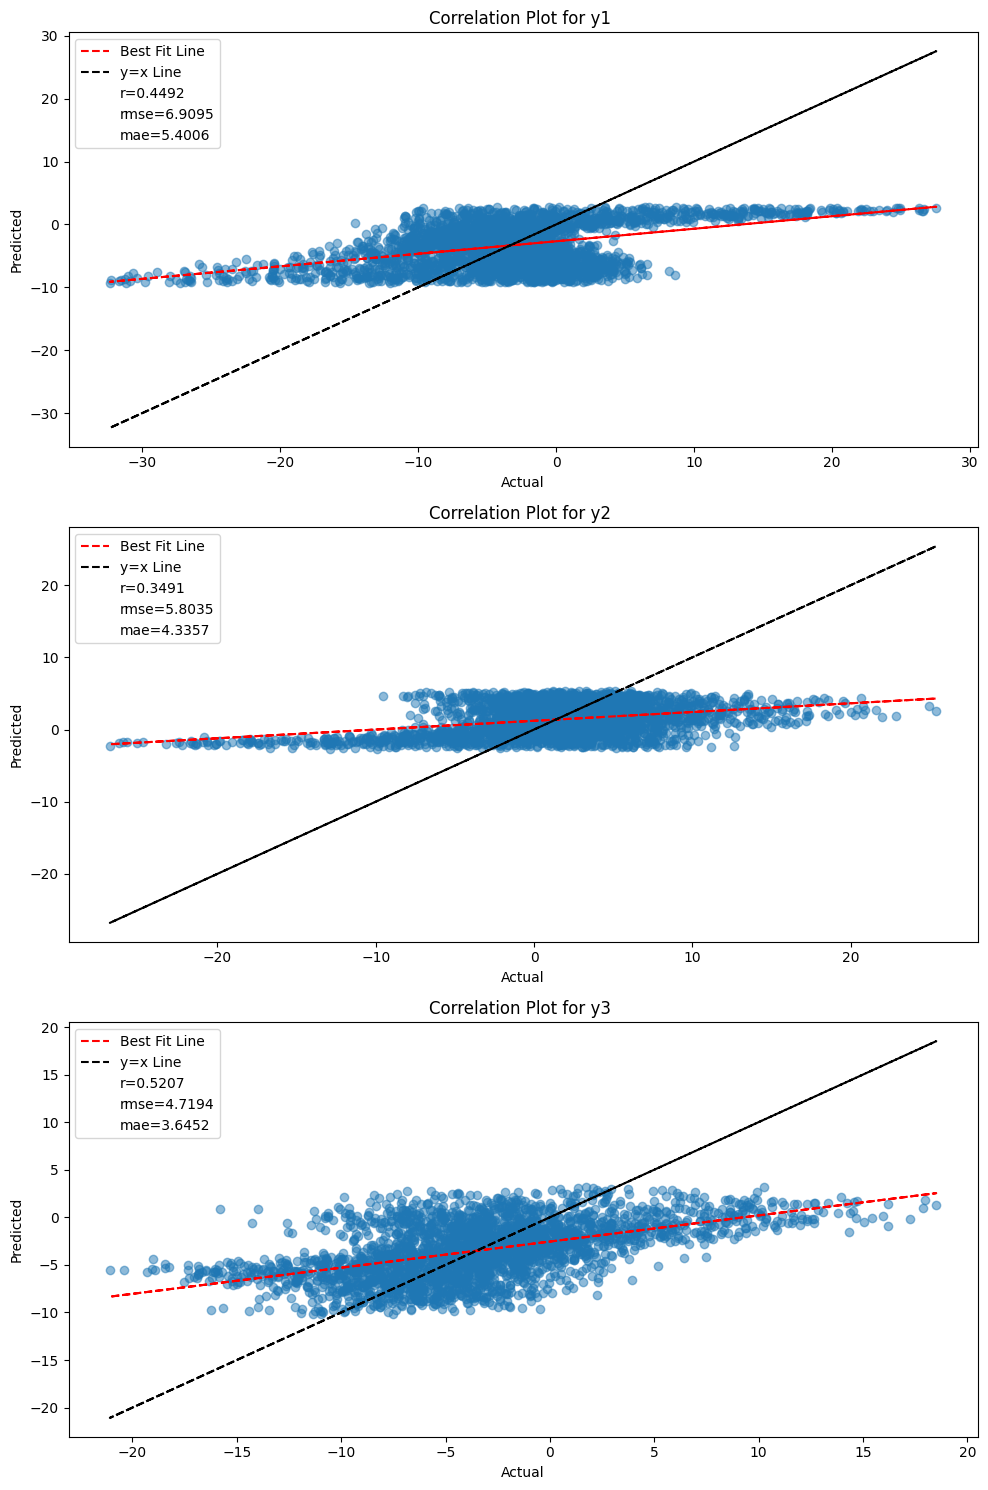

-3.9038*X1^2 + 0.1277*X1^1 + -3.9038*X2^2 + 2.6255*X2^1 + 0.1277 = y1'
-0.0473*X1^2 + -0.2338*X1^1 + -0.0473*X2^2 + -3.0364*X2^1 + -0.2338 = y2'
-3.1080*X1^2 + -2.8652*X1^1 + -3.1080*X2^2 + 1.9663*X2^1 + -2.8652 = y3'
['p<0.001', 'p>0.05', 'p<0.001', 'p<0.001']
['p>0.05', 'p<0.05', 'p<0.001', 'p<0.001']
['p<0.001', 'p<0.001', 'p<0.001', 'p<0.001']


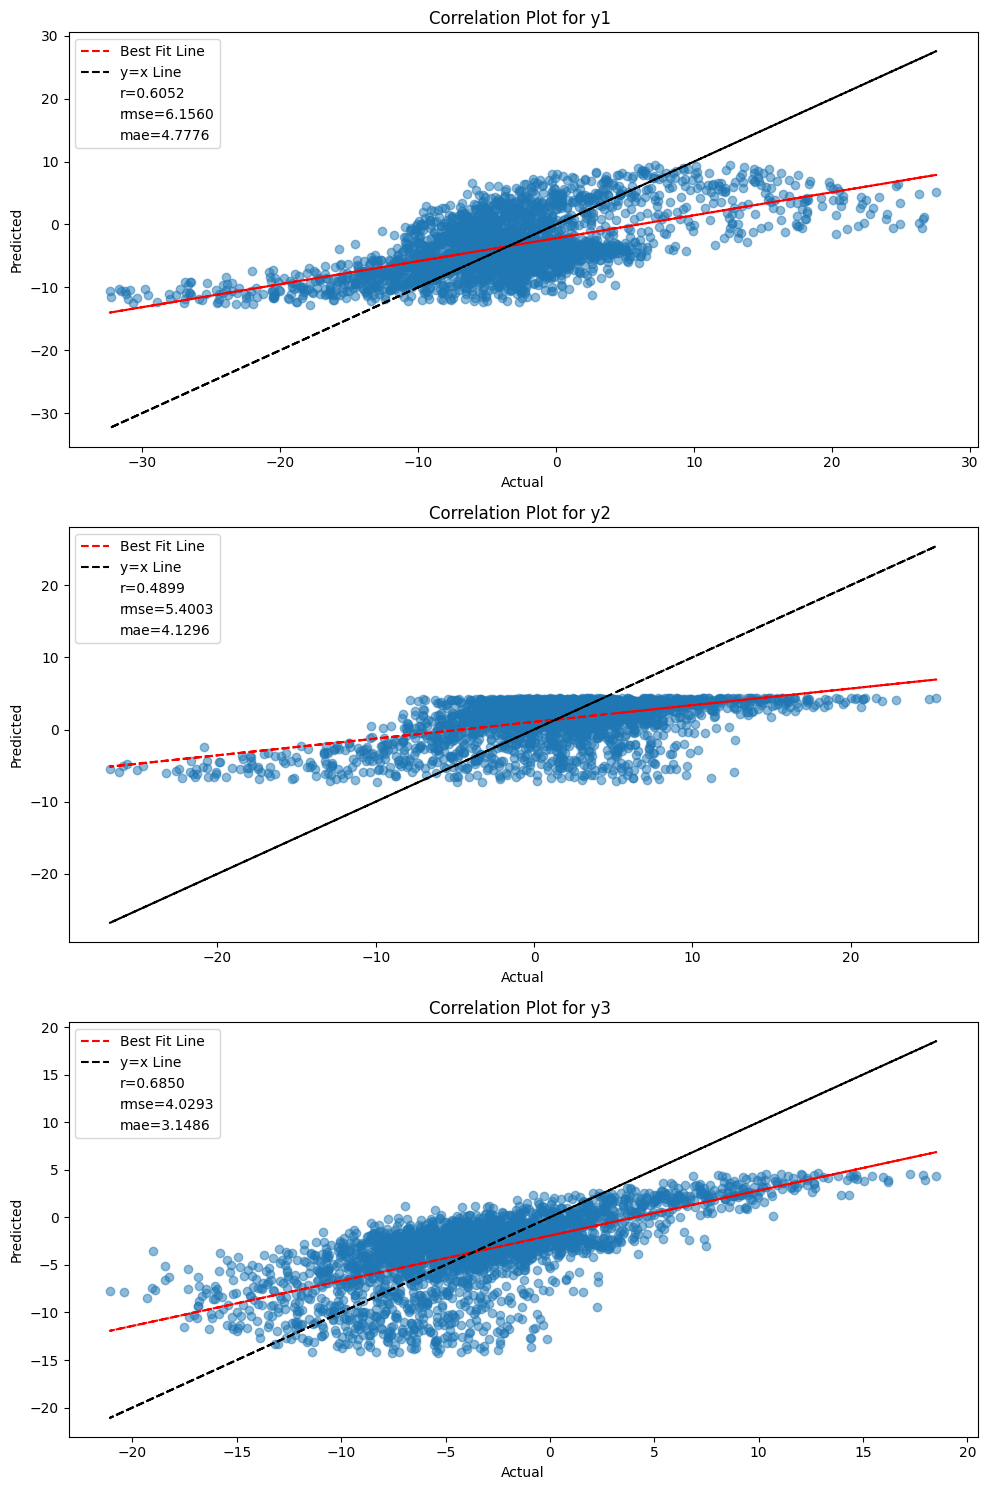

0.2831*X1^3 + -3.9446*X1^2 + -0.2515*X1^1 + 0.2831*X2^3 + -0.2515*X2^2 + 2.7057*X2^1 + -3.9446 = y1'
-4.9319*X1^3 + -0.0277*X1^2 + 6.4036*X1^1 + -4.9319*X2^3 + 6.4036*X2^2 + -3.0577*X2^1 + -0.0277 = y2'
1.7177*X1^3 + -3.0945*X1^2 + -5.1778*X1^1 + 1.7177*X2^3 + -5.1778*X2^2 + 1.9333*X2^1 + -3.0945 = y3'
['p>0.05', 'p<0.001', 'p>0.05', 'p<0.001', 'p<0.001', 'p<0.001']
['p<0.001', 'p>0.05', 'p<0.001', 'p>0.05', 'p<0.001', 'p<0.001']
['p<0.001', 'p<0.001', 'p<0.001', 'p<0.001', 'p<0.001', 'p<0.001']


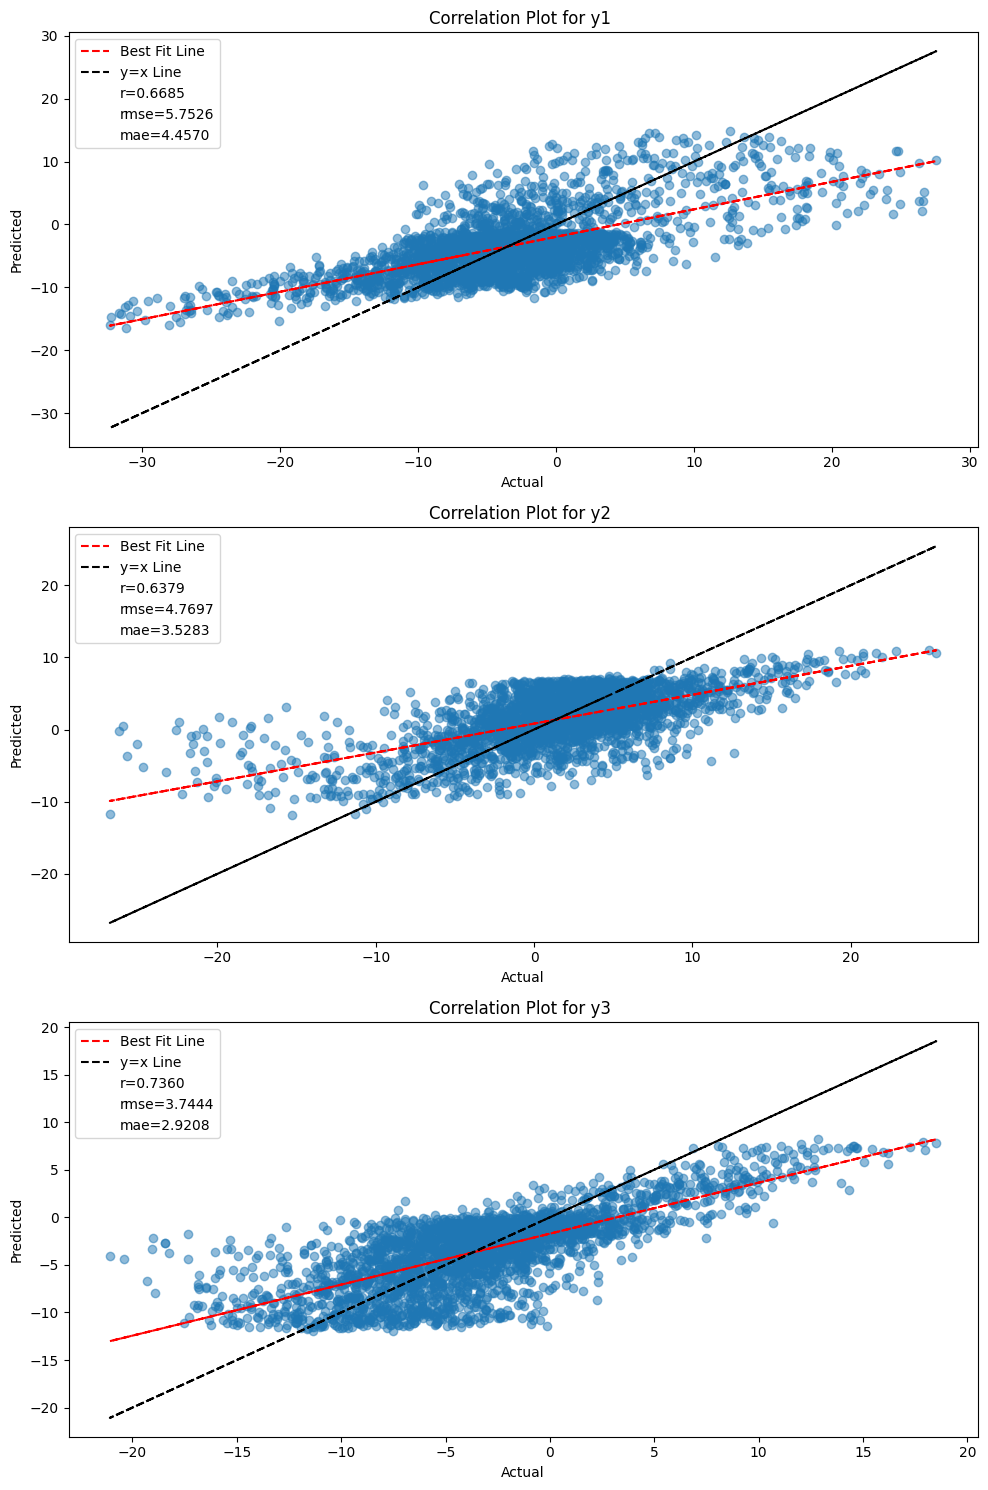

-0.0183*X1^4 + 0.2825*X1^3 + -3.9087*X1^2 + -0.2521*X1^1 + -0.0183*X2^4 + -3.9087*X2^3 + 0.1389*X2^2 + 2.4369*X2^1 + 0.2825 = y1'
-0.1516*X1^4 + -4.9317*X1^3 + 0.2656*X1^2 + 6.4053*X1^1 + -0.1516*X2^4 + 0.2656*X2^3 + -0.0876*X2^2 + -2.8895*X2^1 + -4.9317 = y2'
-0.0511*X1^4 + 1.7177*X1^3 + -2.9957*X1^2 + -5.1773*X1^1 + -0.0511*X2^4 + -2.9957*X2^3 + -0.0147*X2^2 + 1.9613*X2^1 + 1.7177 = y3'
['p>0.05', 'p>0.05', 'p<0.001', 'p>0.05', 'p>0.05', 'p<0.001', 'p<0.001', 'p<0.001']
['p>0.05', 'p<0.001', 'p>0.05', 'p<0.001', 'p>0.05', 'p>0.05', 'p<0.001', 'p<0.001']
['p>0.05', 'p<0.001', 'p<0.001', 'p<0.001', 'p>0.05', 'p<0.001', 'p<0.001', 'p<0.001']


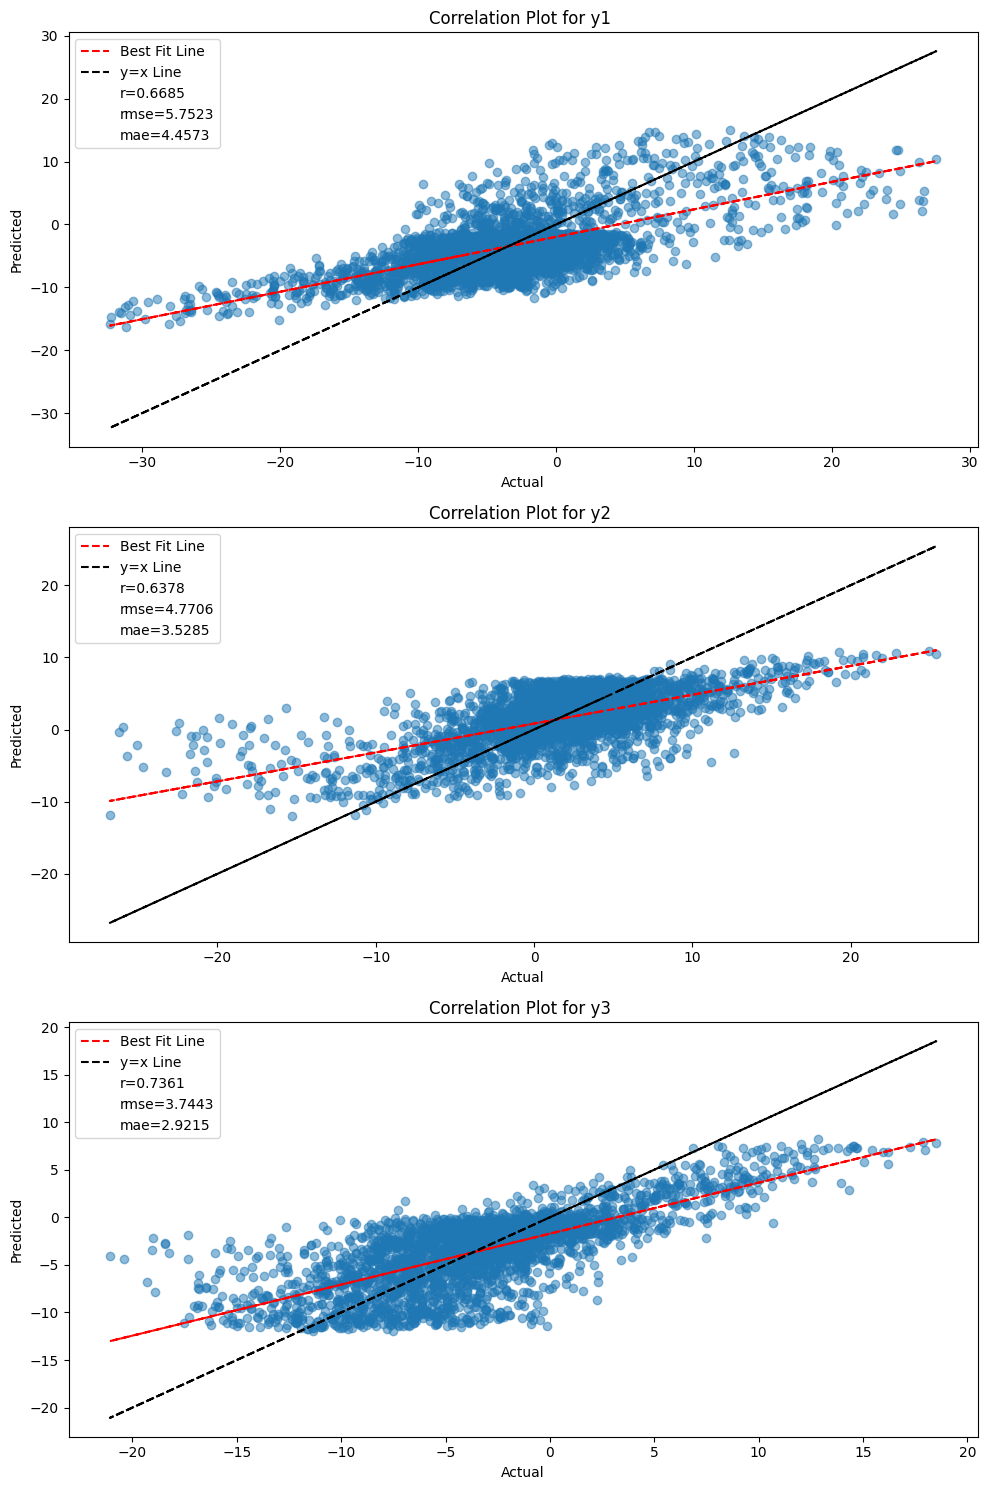

In [52]:
theta_lin = get_theta_poly(X_train, y_train, 1)
print_poly(theta_lin, 1)
plot_y(X_test, y_test, theta_lin, 1)

theta_quad = get_theta_poly(X_train, y_train, 2)
print_poly(theta_quad, 2)
plot_y(X_test, y_test, theta_quad, 2)

theta_cub = get_theta_poly(X_train, y_train, 3)
print_poly(theta_cub, 3)
plot_y(X_test, y_test, theta_cub, 3)

theta_biquad = get_theta_poly(X_train, y_train, 4)
print_poly(theta_biquad, 4)
plot_y(X_test, y_test, theta_biquad, 4)

Emprical Risk(Training) at epoch 1: 88.34163265107925 | Emprical Risk(Validation) at epoch 1: 84.40763056911966
Emprical Risk(Training) at epoch 51: 51.70506927953356 | Emprical Risk(Validation) at epoch 51: 53.04950278071596
Emprical Risk(Training) at epoch 61: 51.698909578043796 | Emprical Risk(Validation) at epoch 61: 53.03630932276075


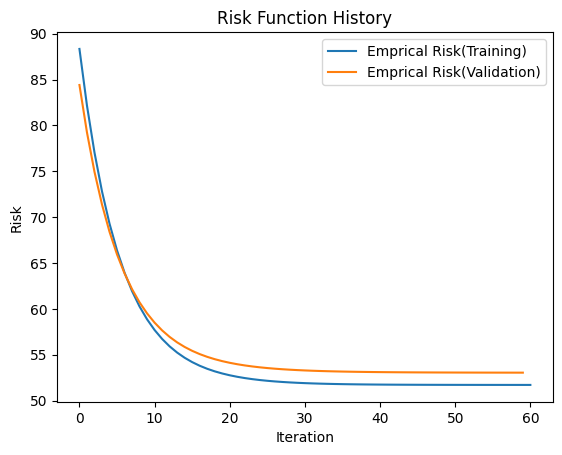

0.0676*X1^1 + 0.0676*X2^1 + 3.9353 = y1'
-0.2133*X1^1 + -0.2133*X2^1 + -2.4503 = y2'
-2.8779*X1^1 + -2.8779*X2^1 + -1.6637 = y3'
['p>0.05', 'p<0.001']
['p>0.05', 'p<0.001']
['p<0.001', 'p<0.001']


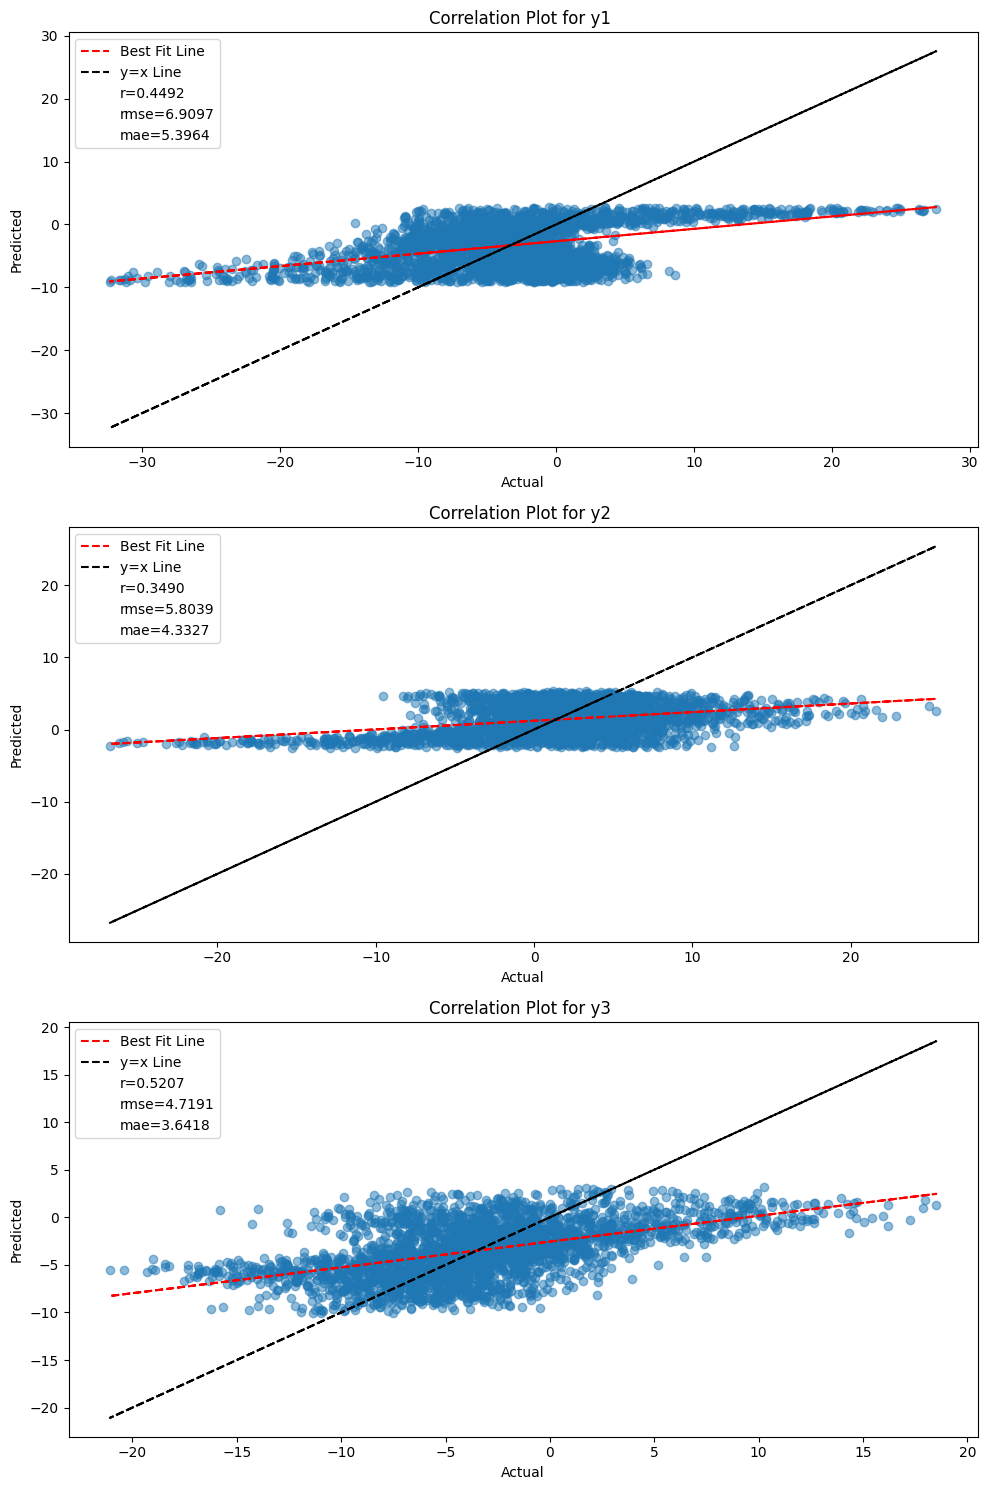

Emprical Risk(Training) at epoch 1: 92.00276770151658 | Emprical Risk(Validation) at epoch 1: 81.36210402476117
Emprical Risk(Training) at epoch 51: 41.99874303993868 | Emprical Risk(Validation) at epoch 51: 42.880537325696906
Emprical Risk(Training) at epoch 101: 41.636749537136616 | Emprical Risk(Validation) at epoch 101: 42.48142437878057
Emprical Risk(Training) at epoch 151: 41.59832553881 | Emprical Risk(Validation) at epoch 151: 42.43837574033042


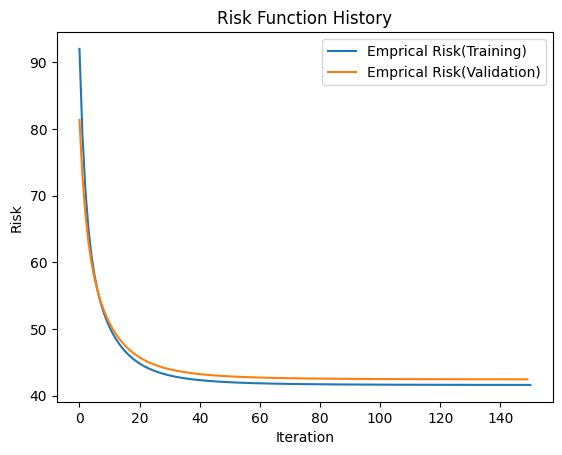

[[-3.93904213  0.0462252  -3.15180823]
 [ 0.12815567 -0.2351625  -2.86461164]
 [ 2.58396743 -2.94077742  1.91806378]
 [ 4.02546537 -2.53711219 -1.645673  ]
 [-2.23693689  3.46258468 -2.65026157]]
['p<0.001', 'p>0.05', 'p<0.001', 'p<0.001']
['p>0.05', 'p<0.05', 'p<0.001', 'p<0.001']
['p<0.001', 'p<0.001', 'p<0.001', 'p<0.001']


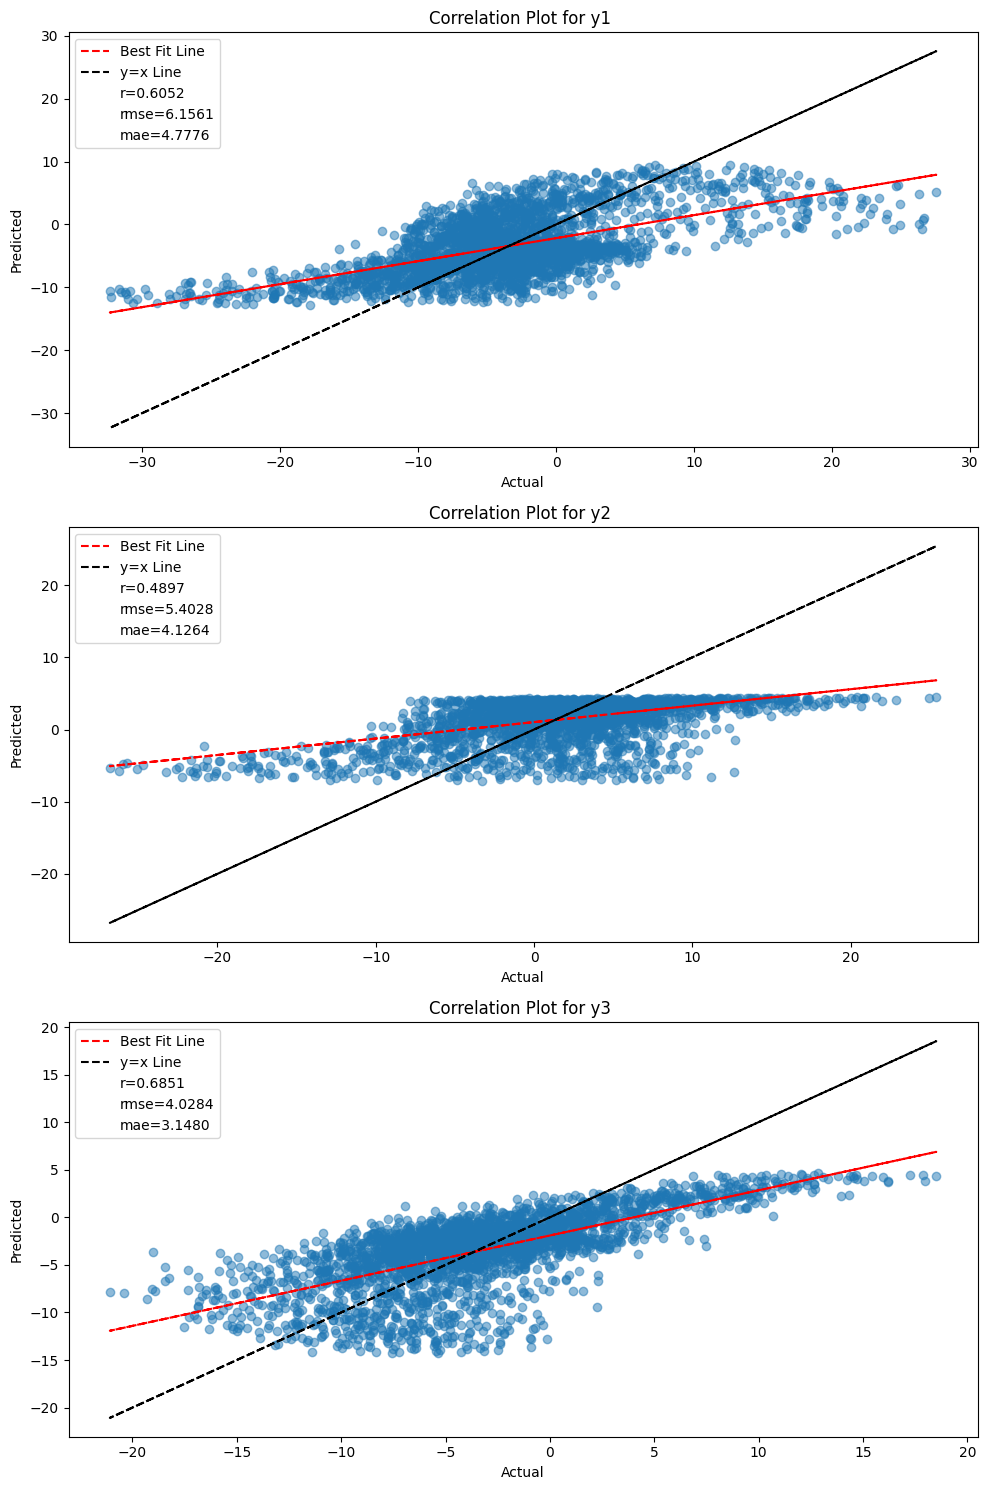

Emprical Risk(Training) at epoch 1: 95.80156387083255 | Emprical Risk(Validation) at epoch 1: 78.77939308848106
Emprical Risk(Training) at epoch 51: 37.922946890222484 | Emprical Risk(Validation) at epoch 51: 38.94898516226407
Emprical Risk(Training) at epoch 101: 36.33987930387171 | Emprical Risk(Validation) at epoch 101: 37.3591195462781
Emprical Risk(Training) at epoch 151: 35.78432885376813 | Emprical Risk(Validation) at epoch 151: 36.795599559815024
Emprical Risk(Training) at epoch 201: 35.561932698160156 | Emprical Risk(Validation) at epoch 201: 36.56784626952106
Emprical Risk(Training) at epoch 251: 35.46998308342721 | Emprical Risk(Validation) at epoch 251: 36.472476279591646
Emprical Risk(Training) at epoch 301: 35.431534499981495 | Emprical Risk(Validation) at epoch 301: 36.4318465154562
Emprical Risk(Training) at epoch 339: 35.41809888836066 | Emprical Risk(Validation) at epoch 339: 36.417566366217166


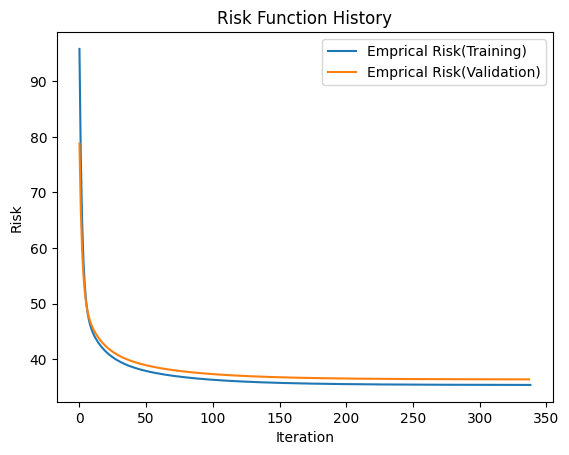

0.2771*X1^3 + -3.9443*X1^2 + -0.2423*X1^1 + 0.2771*X2^3 + -0.2423*X2^2 + 2.7028*X2^1 + -3.9443 = y1'
-4.7020*X1^3 + -0.0230*X1^2 + 6.0533*X1^1 + -4.7020*X2^3 + 6.0533*X2^2 + -3.0544*X2^1 + -0.0230 = y2'
1.5515*X1^3 + -3.0970*X1^2 + -4.9246*X1^1 + 1.5515*X2^3 + -4.9246*X2^2 + 1.9323*X2^1 + -3.0970 = y3'
['p>0.05', 'p<0.001', 'p>0.05', 'p<0.001', 'p<0.001', 'p<0.001']
['p<0.001', 'p>0.05', 'p<0.001', 'p>0.05', 'p<0.001', 'p<0.001']
['p<0.001', 'p<0.001', 'p<0.001', 'p<0.001', 'p<0.001', 'p<0.001']


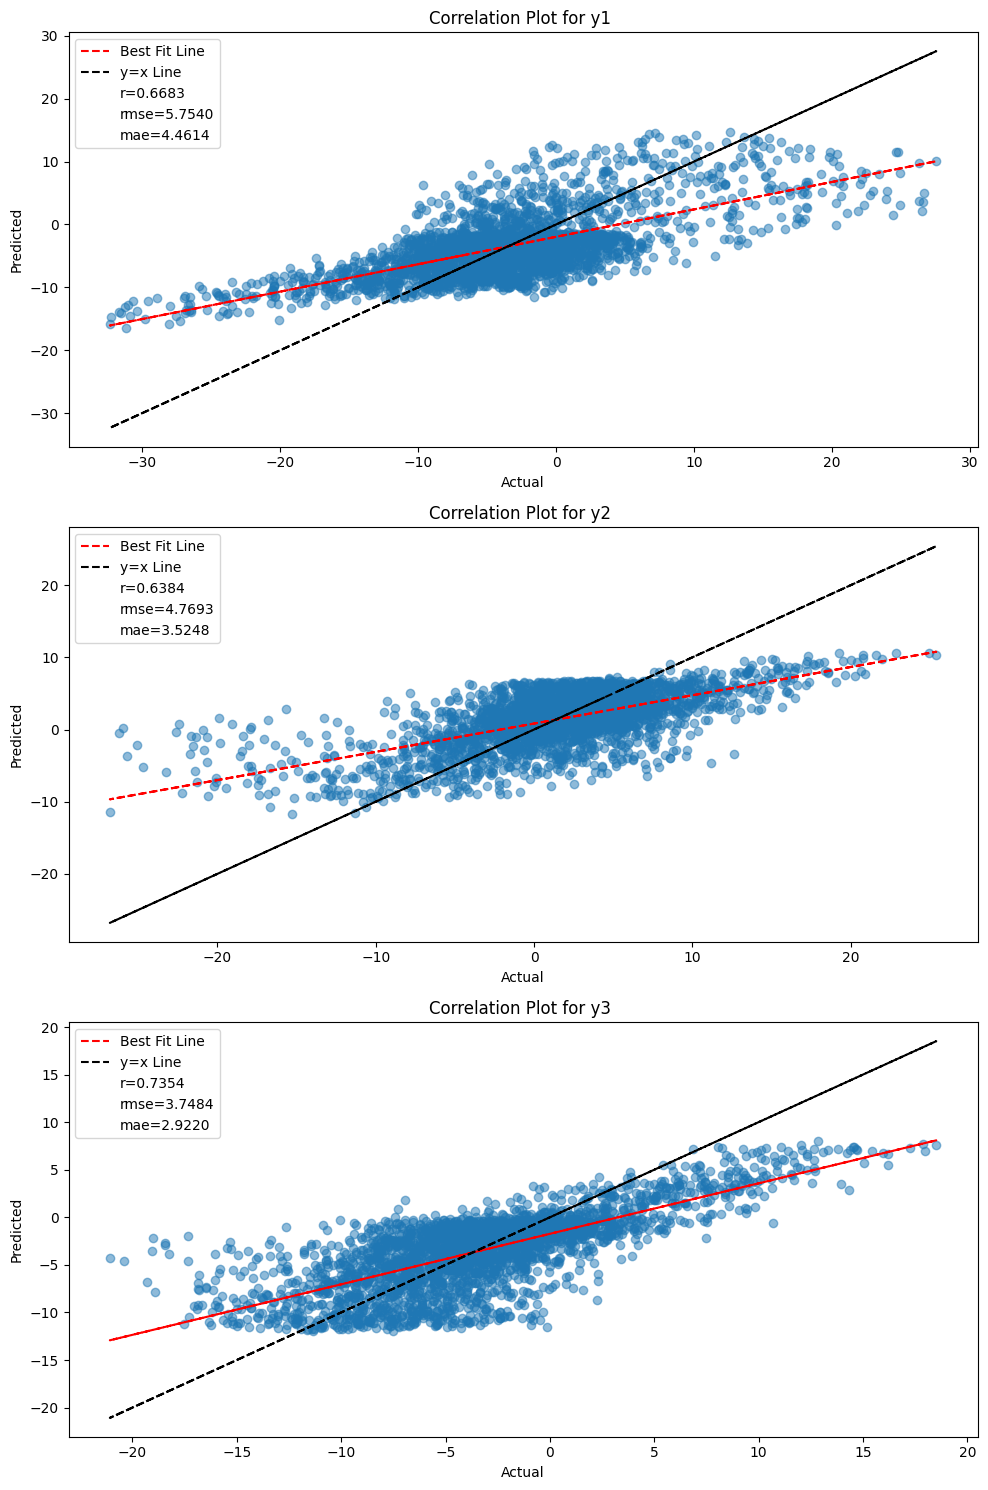

Emprical Risk(Training) at epoch 1: 112.69278504326874 | Emprical Risk(Validation) at epoch 1: 69.43889144096303
Emprical Risk(Training) at epoch 51: 37.767299624460264 | Emprical Risk(Validation) at epoch 51: 39.15225793903542
Emprical Risk(Training) at epoch 101: 36.528520675096644 | Emprical Risk(Validation) at epoch 101: 37.863178505211714
Emprical Risk(Training) at epoch 151: 35.9922834492139 | Emprical Risk(Validation) at epoch 151: 37.285841983650215
Emprical Risk(Training) at epoch 201: 35.73751643263372 | Emprical Risk(Validation) at epoch 201: 36.99356884259385
Emprical Risk(Training) at epoch 251: 35.608188937573786 | Emprical Risk(Validation) at epoch 251: 36.8305521563129
Emprical Risk(Training) at epoch 301: 35.537165407829626 | Emprical Risk(Validation) at epoch 301: 36.72992663541918
Emprical Risk(Training) at epoch 351: 35.49482893185138 | Emprical Risk(Validation) at epoch 351: 36.66188880711267
Emprical Risk(Training) at epoch 401: 35.467680922433686 | Emprical Risk(

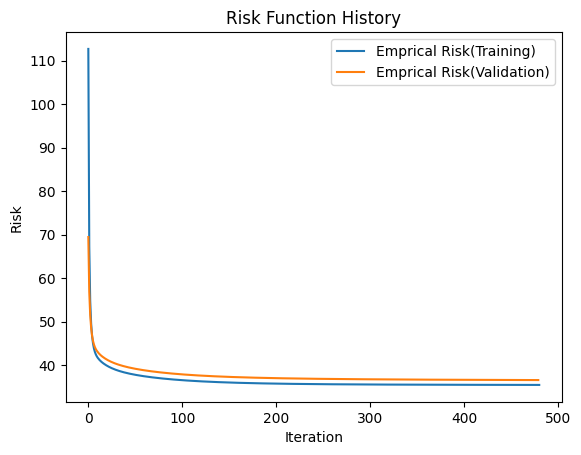

-0.3766*X1^4 + 0.2756*X1^3 + -3.1645*X1^2 + -0.2433*X1^1 + -0.3766*X2^4 + -3.1645*X2^3 + 0.4420*X2^2 + 1.8075*X2^1 + 0.2756 = y1'
-0.2502*X1^4 + -4.8649*X1^3 + 0.4797*X1^2 + 6.3084*X1^1 + -0.2502*X2^4 + 0.4797*X2^3 + -0.4754*X2^2 + -2.0775*X2^1 + -4.8649 = y2'
-0.3044*X1^4 + 1.6729*X1^3 + -2.4706*X1^2 + -5.1107*X1^1 + -0.3044*X2^4 + -2.4706*X2^3 + 0.2375*X2^2 + 1.4375*X2^1 + 1.6729 = y3'
['p>0.05', 'p>0.05', 'p<0.001', 'p>0.05', 'p>0.05', 'p<0.001', 'p<0.001', 'p<0.001']
['p>0.05', 'p<0.001', 'p>0.05', 'p<0.001', 'p<0.05', 'p>0.05', 'p<0.001', 'p<0.001']
['p>0.05', 'p<0.001', 'p<0.001', 'p<0.001', 'p>0.05', 'p<0.001', 'p<0.001', 'p<0.001']


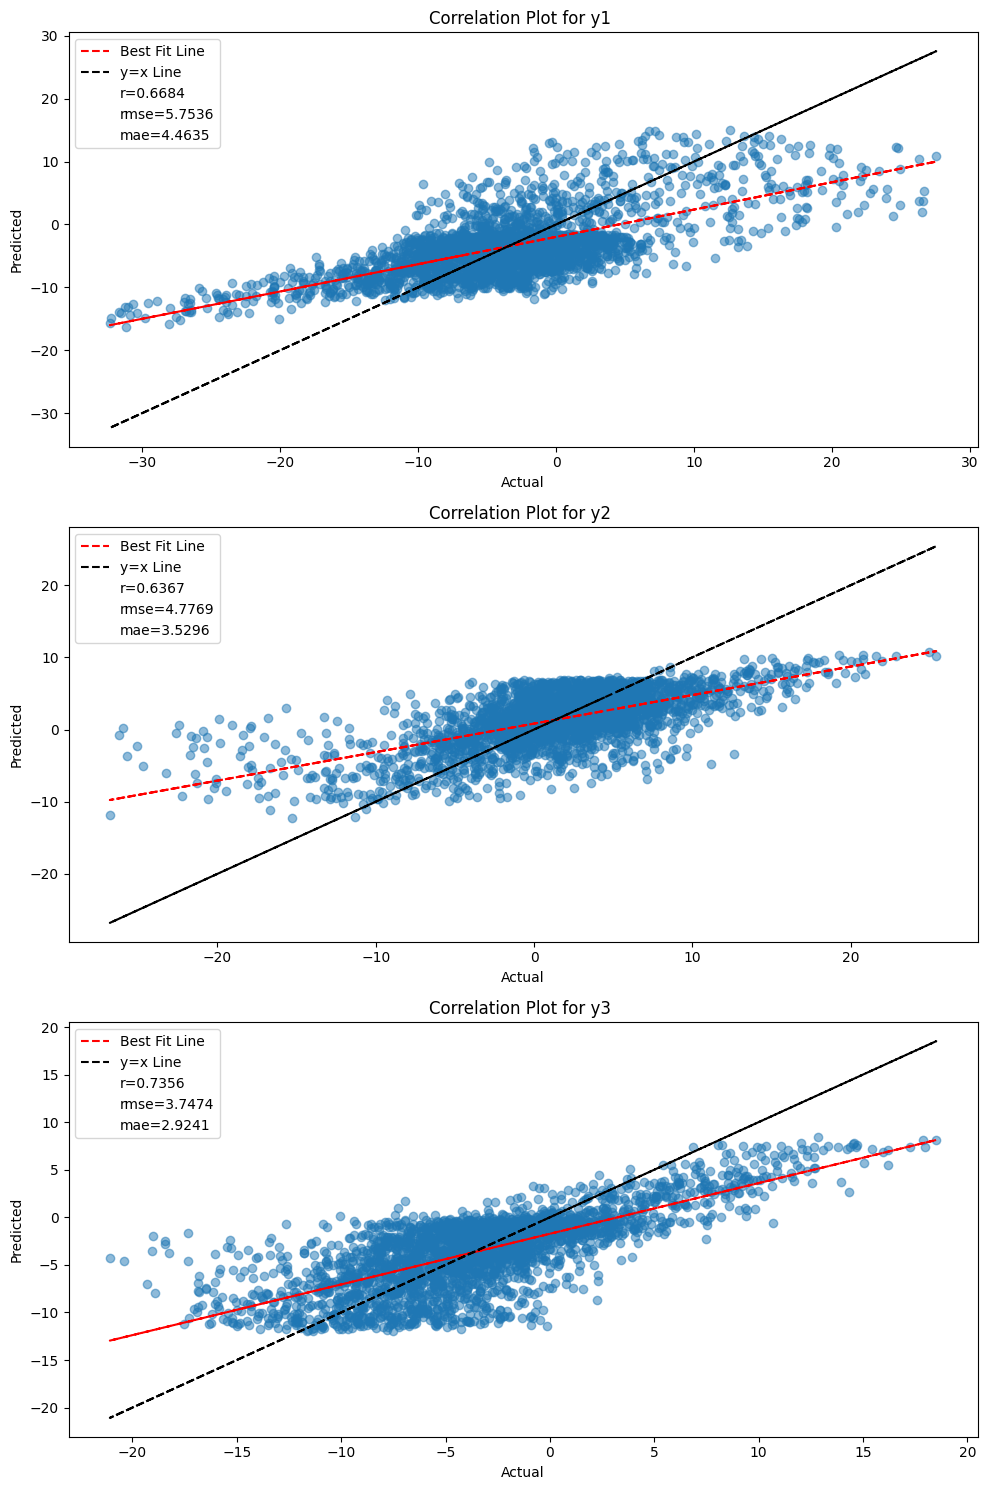

In [53]:
theta_gd_lin, train_losses, val_losses = grad_desc_sq_err(
    X_train, y_train, X_val, y_val)
plot_train_loss(train_losses, val_losses)
print_poly(theta_gd_lin)  
plot_y(X_test, y_test, theta_gd_lin, 1)

theta_gd_quad, train_losses, val_losses = grad_desc_sq_err(
    X_train, y_train, X_val, y_val, 2)
plot_train_loss(train_losses, val_losses)
print(theta_gd_quad)
plot_y(X_test, y_test, theta_gd_quad, 2)

theta_gd_cub, train_losses, val_losses = grad_desc_sq_err(
    X_train, y_train, X_val, y_val, 3)
plot_train_loss(train_losses, val_losses)
print_poly(theta_gd_cub, 3)
plot_y(X_test, y_test, theta_gd_cub, 3)

theta_gd_biquad, train_losses, val_losses = grad_desc_sq_err(
    X_train, y_train, X_val, y_val, 4)
plot_train_loss(train_losses, val_losses)
print_poly(theta_gd_biquad, 4)
plot_y(X_test, y_test, theta_gd_biquad, 4)

Emprical Risk(Training) at epoch 1: 84.04109944650996 | Emprical Risk(Validation) at epoch 1: 73.78746518809342
Emprical Risk(Training) at epoch 51: 47.14039884486837 | Emprical Risk(Validation) at epoch 51: 48.11686403000168
Emprical Risk(Training) at epoch 101: 47.58689316521373 | Emprical Risk(Validation) at epoch 101: 48.51169817522923
Emprical Risk(Training) at epoch 148: 47.75263307187785 |  Emprical Risk(Validation) at epoch 148: 48.667003953913444


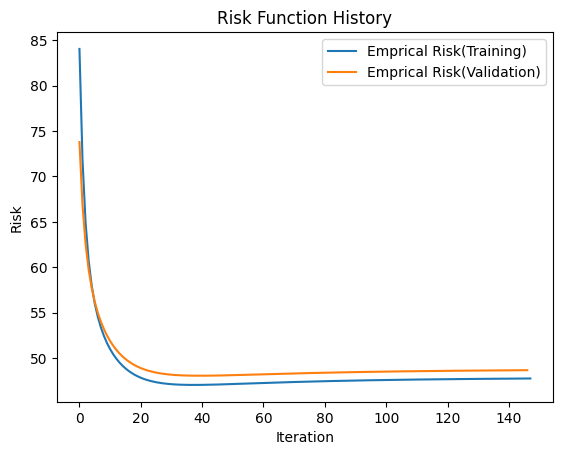

-3.6893*X1^2 + 0.7416*X1^1 + -3.6893*X2^2 + 2.8594*X2^1 + 0.7416 = y1'
0.2926*X1^2 + 0.3783*X1^1 + 0.2926*X2^2 + -2.6674*X2^1 + 0.3783 = y2'
-2.9082*X1^2 + -2.2511*X1^1 + -2.9082*X2^2 + 2.1881*X2^1 + -2.2511 = y3'
['p<0.001', 'p<0.001', 'p<0.001', 'p<0.001']
['p<0.05', 'p<0.01', 'p<0.001', 'p<0.001']
['p<0.001', 'p<0.001', 'p<0.001', 'p<0.001']


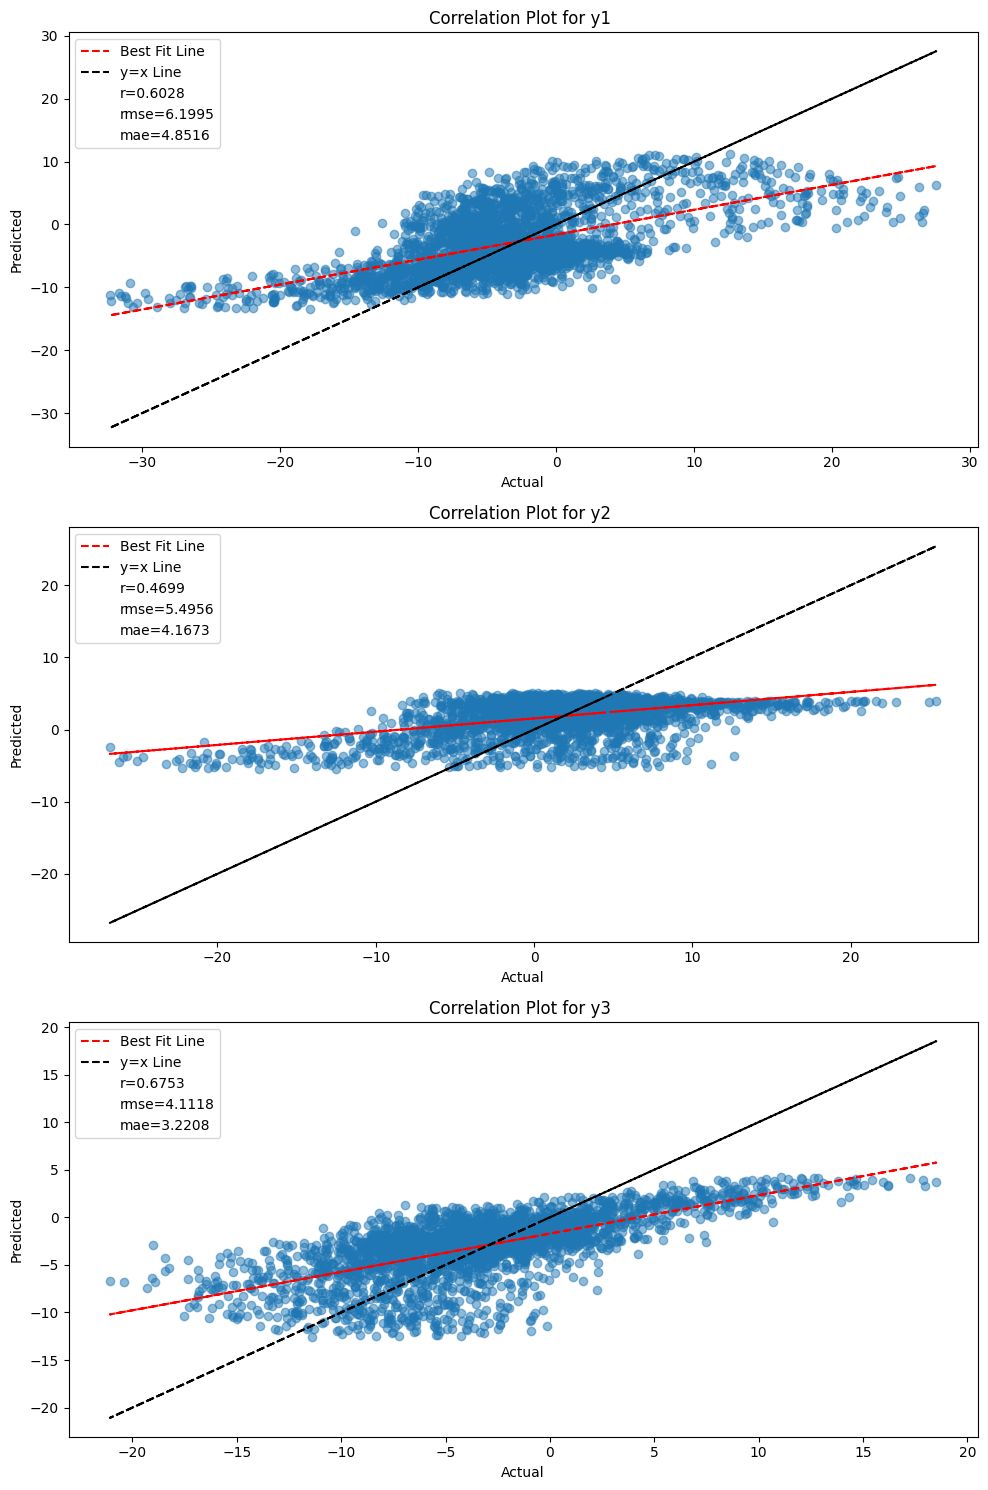

Emprical Risk(Training) at epoch 1: 77.05240883485777 | Emprical Risk(Validation) at epoch 1: 65.72381140265176
Emprical Risk(Training) at epoch 51: 42.5989880787821 | Emprical Risk(Validation) at epoch 51: 43.73628186416648
Emprical Risk(Training) at epoch 101: 43.10415030341177 | Emprical Risk(Validation) at epoch 101: 44.19825332167352
Emprical Risk(Training) at epoch 151: 43.9766737643299 | Emprical Risk(Validation) at epoch 151: 45.03909323567924
Emprical Risk(Training) at epoch 201: 44.750064809876804 | Emprical Risk(Validation) at epoch 201: 45.79127348883067
Emprical Risk(Training) at epoch 251: 45.33507041054067 | Emprical Risk(Validation) at epoch 251: 46.362530775239044
Emprical Risk(Training) at epoch 301: 45.74795760054592 | Emprical Risk(Validation) at epoch 301: 46.76666220731978
Emprical Risk(Training) at epoch 338: 45.96641351718374 |  Emprical Risk(Validation) at epoch 338: 46.975785604045804


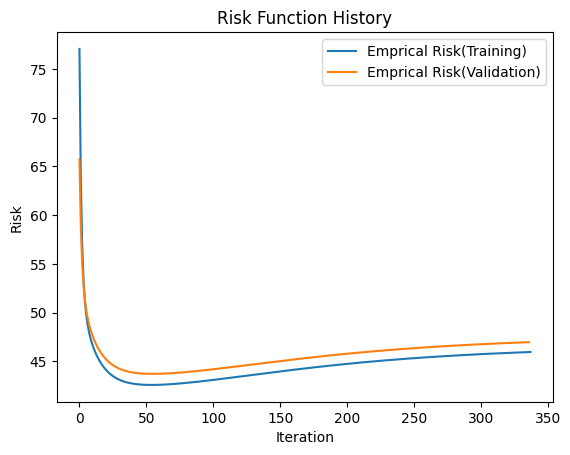

-0.2330*X1^3 + -3.7272*X1^2 + 0.9684*X1^1 + -0.2330*X2^3 + 0.9684*X2^2 + 2.9245*X2^1 + -3.7272 = y1'
-5.1931*X1^3 + 0.1941*X1^2 + 7.2352*X1^1 + -5.1931*X2^3 + 7.2352*X2^2 + -2.8326*X2^1 + 0.1941 = y2'
1.0645*X1^3 + -2.8798*X1^2 + -3.7491*X1^1 + 1.0645*X2^3 + -3.7491*X2^2 + 2.1539*X2^1 + -2.8798 = y3'
['p>0.05', 'p<0.001', 'p<0.01', 'p<0.001', 'p<0.001', 'p>0.05']
['p<0.001', 'p>0.05', 'p<0.001', 'p<0.001', 'p<0.001', 'p<0.001']
['p<0.001', 'p<0.001', 'p<0.001', 'p<0.001', 'p<0.001', 'p<0.001']


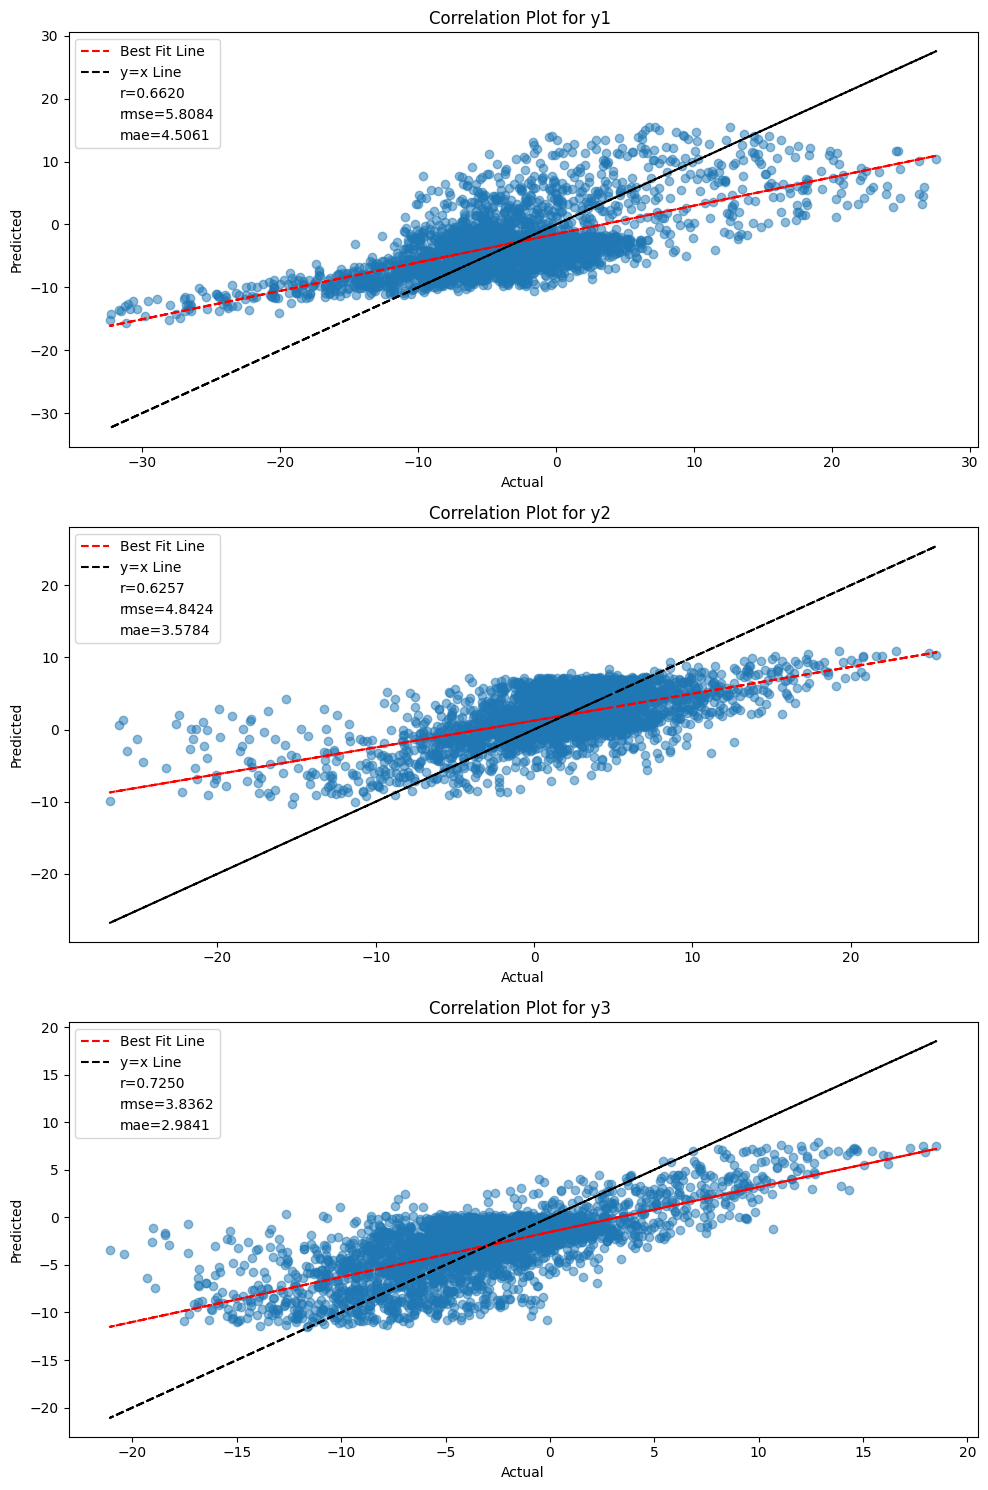

Emprical Risk(Training) at epoch 1: 91.7557833185868 | Emprical Risk(Validation) at epoch 1: 60.77893854602012
Emprical Risk(Training) at epoch 51: 41.29670049023004 | Emprical Risk(Validation) at epoch 51: 42.76402632985907
Emprical Risk(Training) at epoch 101: 41.655510746629346 | Emprical Risk(Validation) at epoch 101: 43.0571516986921
Emprical Risk(Training) at epoch 151: 42.470151388660376 | Emprical Risk(Validation) at epoch 151: 43.823678342087504
Emprical Risk(Training) at epoch 201: 43.2834643302874 | Emprical Risk(Validation) at epoch 201: 44.59769660694042
Emprical Risk(Training) at epoch 251: 43.96263026739583 | Emprical Risk(Validation) at epoch 251: 45.244839018639986
Emprical Risk(Training) at epoch 301: 44.494668819047256 | Emprical Risk(Validation) at epoch 301: 45.75093259760541
Emprical Risk(Training) at epoch 351: 44.9033183176664 | Emprical Risk(Validation) at epoch 351: 46.138474298322485
Emprical Risk(Training) at epoch 401: 45.217529464536305 | Emprical Risk(Val

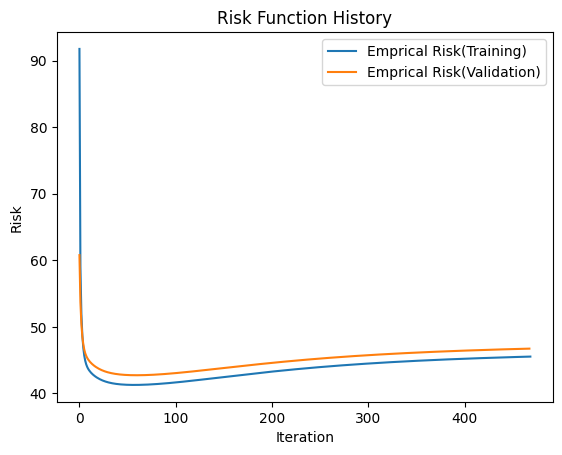

-1.0771*X1^4 + -0.1089*X1^3 + -1.6989*X1^2 + 0.6696*X1^1 + -1.0771*X2^4 + -1.6989*X2^3 + -0.3503*X2^2 + 3.4633*X2^1 + -0.1089 = y1'
-0.9957*X1^4 + -5.2401*X1^3 + 2.0385*X1^2 + 7.2067*X1^1 + -0.9957*X2^4 + 2.0385*X2^3 + -1.2188*X2^2 + -0.5232*X2^1 + -5.2401 = y2'
-1.0272*X1^4 + 1.2825*X1^3 + -0.9596*X1^2 + -4.1897*X1^1 + -1.0272*X2^4 + -0.9596*X2^3 + -0.4902*X2^2 + 2.9588*X2^1 + 1.2825 = y3'
['p<0.001', 'p>0.05', 'p<0.001', 'p<0.05', 'p>0.05', 'p<0.001', 'p<0.001', 'p>0.05']
['p<0.001', 'p<0.001', 'p<0.001', 'p<0.001', 'p<0.001', 'p<0.01', 'p>0.05', 'p<0.001']
['p<0.001', 'p<0.001', 'p<0.01', 'p<0.001', 'p<0.01', 'p<0.001', 'p<0.001', 'p<0.001']


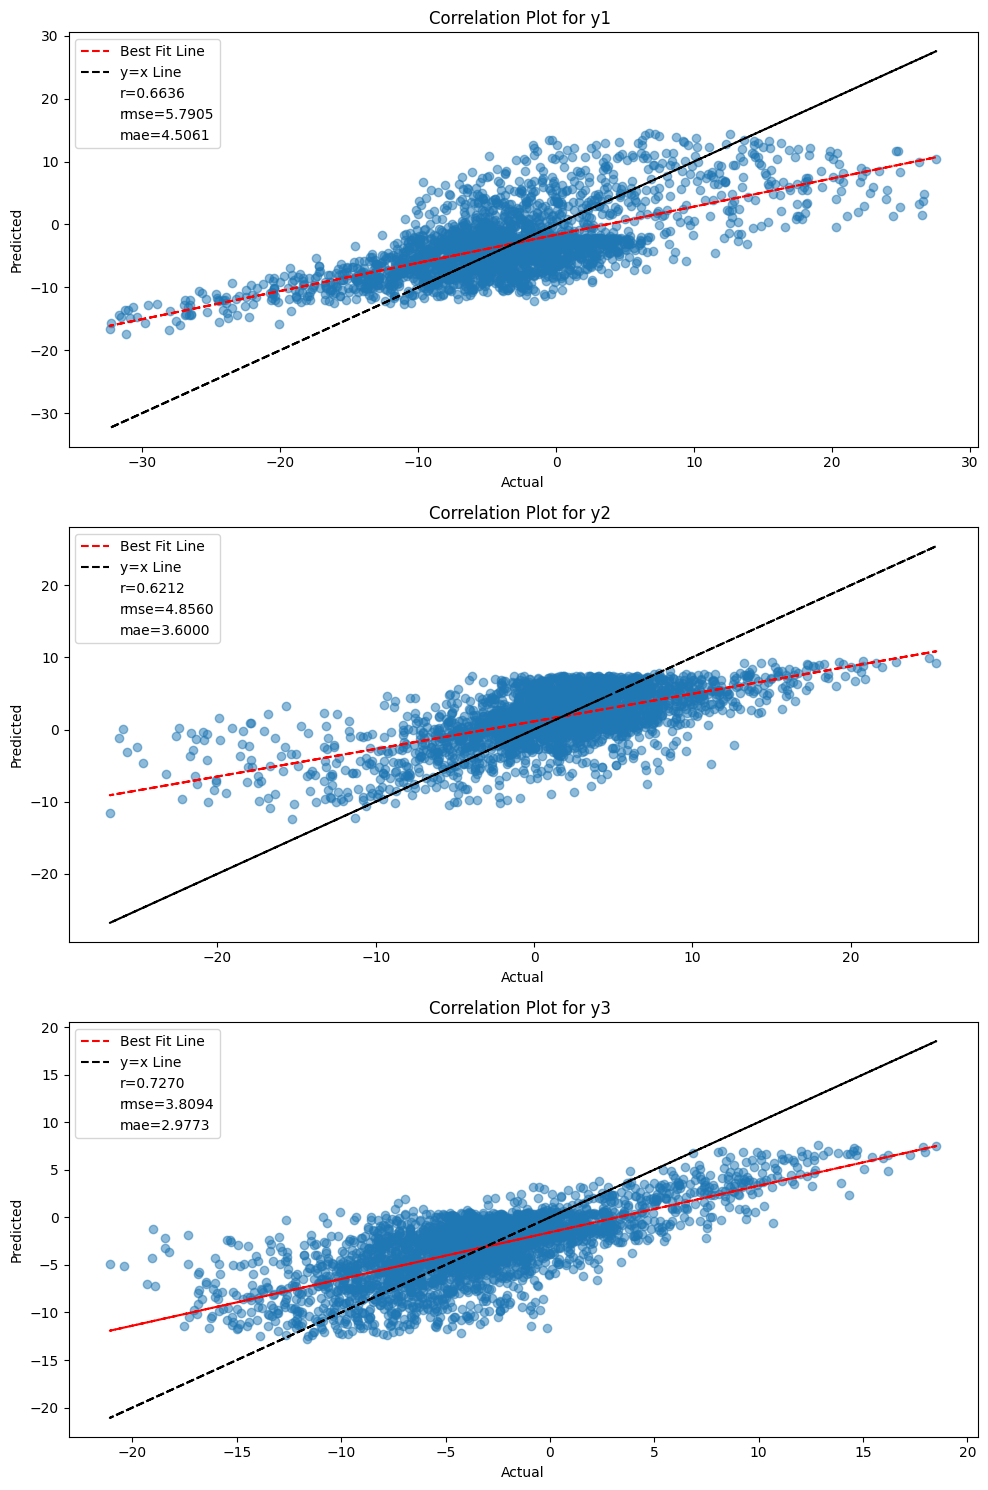

In [54]:
theta_gd_quad_reg_l2, train_losses, val_losses = grad_desc_sq_err_reg_L2(
    X_train, y_train, X_val, y_val, 2)
plot_train_loss(train_losses, val_losses)
print_poly(theta_gd_quad_reg_l2, 2)
plot_y(X_test, y_test, theta_gd_quad_reg_l2, 2)


theta_gd_cub_reg_l2, train_losses, val_losses = grad_desc_sq_err_reg_L2(
    X_train, y_train, X_val, y_val, 3)
plot_train_loss(train_losses, val_losses)
print_poly(theta_gd_cub_reg_l2, 3)
plot_y(X_test, y_test, theta_gd_cub_reg_l2, 3)


theta_gd_biquad_reg_l2, train_losses, val_losses = grad_desc_sq_err_reg_L2(
    X_train, y_train, X_val, y_val, 4)
plot_train_loss(train_losses, val_losses)
print_poly(theta_gd_biquad_reg_l2, 4)
plot_y(X_test, y_test, theta_gd_biquad_reg_l2, 4)

Emprical Risk(Training) at epoch 1: 80.37966555808066 | Emprical Risk(Validation) at epoch 1: 72.87161807865694
Emprical Risk(Training) at epoch 51: 45.175647553889014 | Emprical Risk(Validation) at epoch 51: 46.1253023435932
Emprical Risk(Training) at epoch 101: 44.93411034607438 | Emprical Risk(Validation) at epoch 101: 45.846544369484256
Emprical Risk(Training) at epoch 106: 44.92870584730322 |  Emprical Risk(Validation) at epoch 106: 45.840790494437314


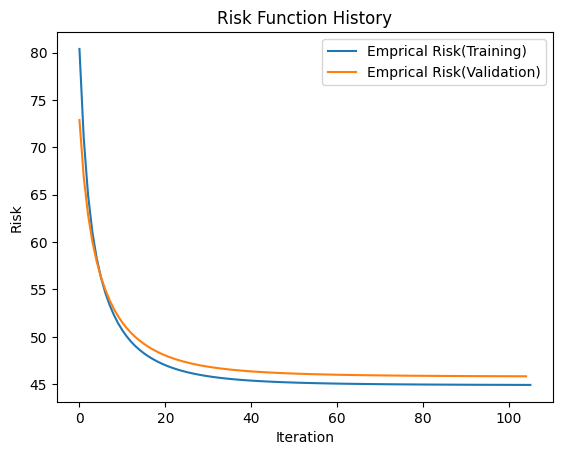

-3.8939*X1^2 + 0.0118*X1^1 + -3.8939*X2^2 + 2.1395*X2^1 + 0.0118 = y1'
0.0790*X1^2 + -0.0998*X1^1 + 0.0790*X2^2 + -2.4425*X2^1 + -0.0998 = y2'
-3.1030*X1^2 + -2.7310*X1^1 + -3.1030*X2^2 + 1.5050*X2^1 + -2.7310 = y3'
['p<0.001', 'p>0.05', 'p<0.001', 'p<0.001']
['p>0.05', 'p>0.05', 'p<0.001', 'p<0.001']
['p<0.001', 'p<0.001', 'p<0.001', 'p<0.001']


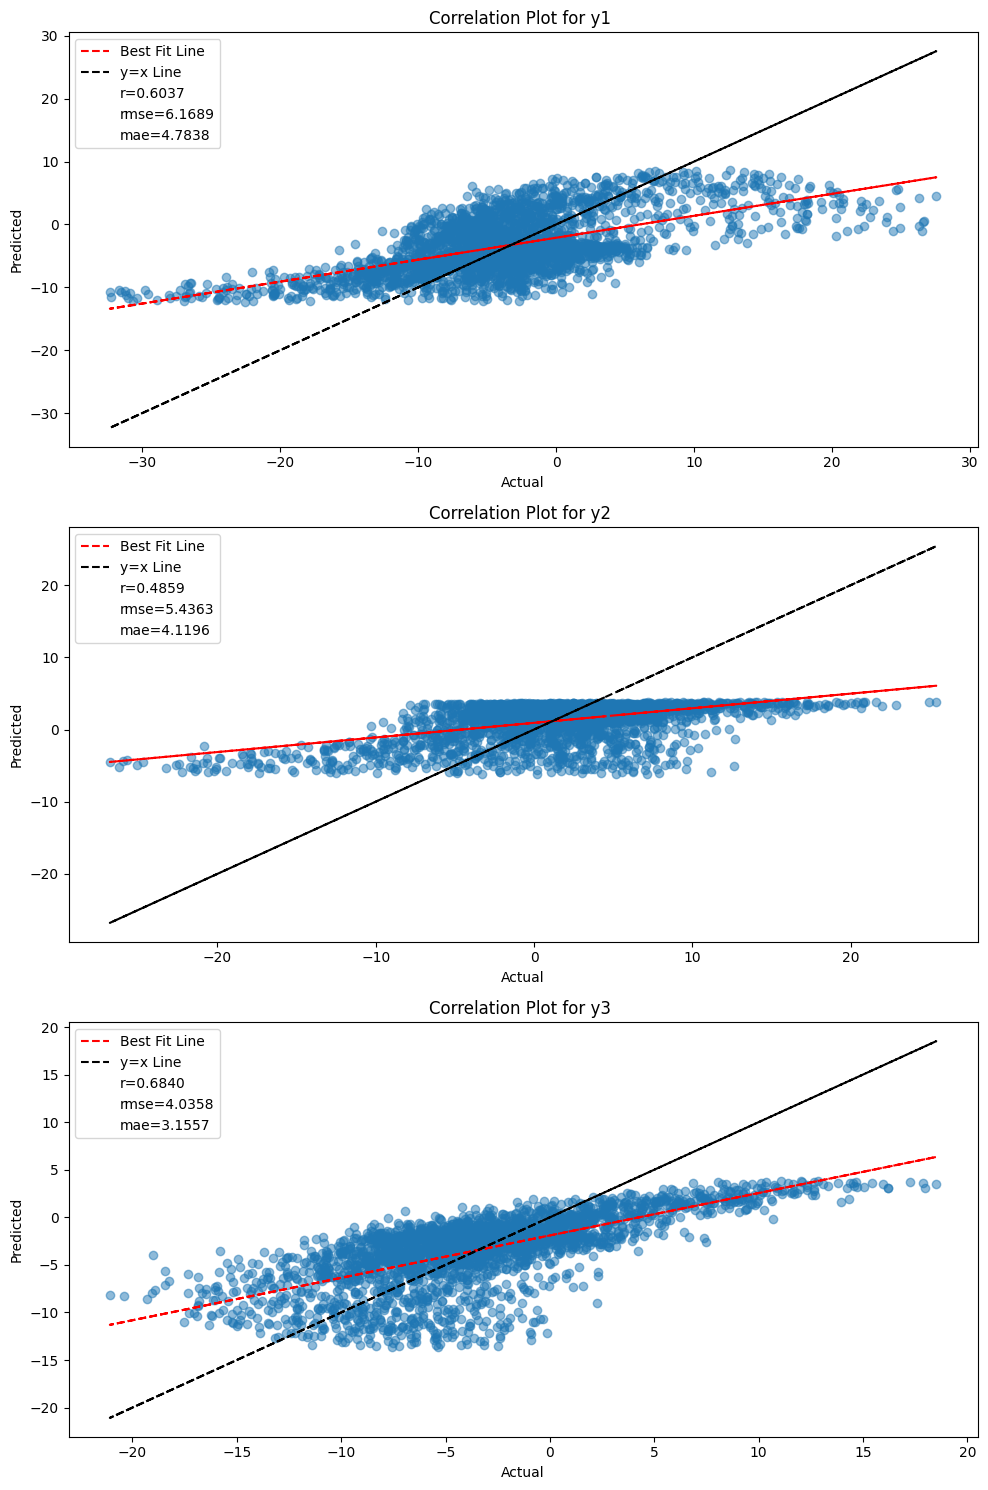

Emprical Risk(Training) at epoch 1: 82.59134085078415 | Emprical Risk(Validation) at epoch 1: 70.60861544831418
Emprical Risk(Training) at epoch 51: 41.526659243951286 | Emprical Risk(Validation) at epoch 51: 42.5972469131696
Emprical Risk(Training) at epoch 101: 40.53461307969483 | Emprical Risk(Validation) at epoch 101: 41.59183888695459
Emprical Risk(Training) at epoch 151: 40.272864136624676 | Emprical Risk(Validation) at epoch 151: 41.316574034180896
Emprical Risk(Training) at epoch 201: 40.17248848225334 | Emprical Risk(Validation) at epoch 201: 41.20987137031204
Emprical Risk(Training) at epoch 251: 40.132153159166506 | Emprical Risk(Validation) at epoch 251: 41.16529104061884
Emprical Risk(Training) at epoch 294: 40.11629440829674 |  Emprical Risk(Validation) at epoch 294: 41.14733409436109


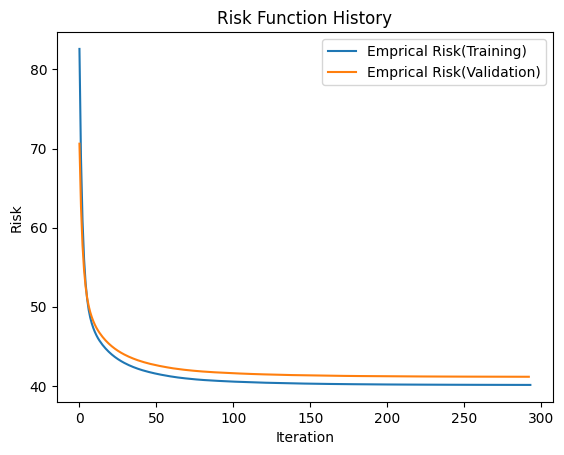

0.0604*X1^3 + -3.8773*X1^2 + 0.0035*X1^1 + 0.0604*X2^3 + 0.0035*X2^2 + 2.3046*X2^1 + -3.8773 = y1'
-3.7555*X1^3 + 0.0028*X1^2 + 4.6368*X1^1 + -3.7555*X2^3 + 4.6368*X2^2 + -2.6659*X2^1 + 0.0028 = y2'
0.7023*X1^3 + -3.0451*X1^2 + -3.6574*X1^1 + 0.7023*X2^3 + -3.6574*X2^2 + 1.5545*X2^1 + -3.0451 = y3'
['p>0.05', 'p<0.001', 'p>0.05', 'p<0.001', 'p<0.001', 'p>0.05']
['p<0.001', 'p>0.05', 'p<0.001', 'p>0.05', 'p<0.001', 'p<0.001']
['p<0.001', 'p<0.001', 'p<0.001', 'p<0.001', 'p<0.001', 'p>0.05']


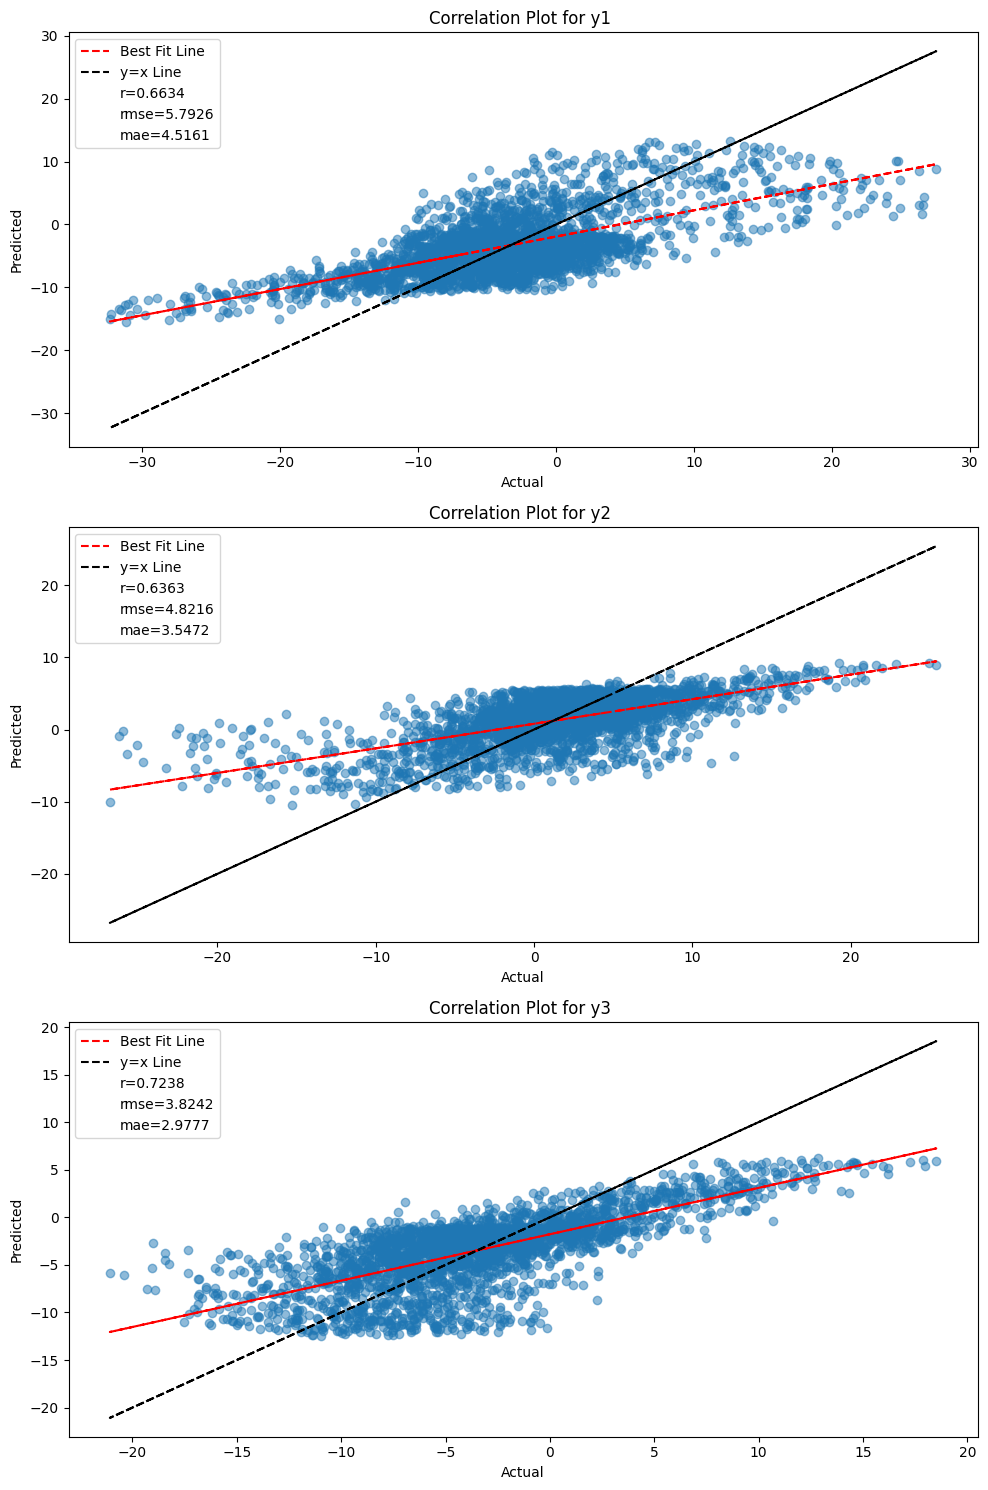

Emprical Risk(Training) at epoch 1: 87.5793130112277 | Emprical Risk(Validation) at epoch 1: 63.860423935400334
Emprical Risk(Training) at epoch 51: 41.09342889506354 | Emprical Risk(Validation) at epoch 51: 42.54867021597901
Emprical Risk(Training) at epoch 101: 40.32789289327456 | Emprical Risk(Validation) at epoch 101: 41.750468137684614
Emprical Risk(Training) at epoch 151: 40.07997749142911 | Emprical Risk(Validation) at epoch 151: 41.47361651245315
Emprical Risk(Training) at epoch 201: 39.97207273766631 | Emprical Risk(Validation) at epoch 201: 41.34435147958003
Emprical Risk(Training) at epoch 251: 39.92222077096877 | Emprical Risk(Validation) at epoch 251: 41.27681396809117
Emprical Risk(Training) at epoch 301: 39.89824084265182 | Emprical Risk(Validation) at epoch 301: 41.23558998301122
Emprical Risk(Training) at epoch 351: 39.88587620442788 | Emprical Risk(Validation) at epoch 351: 41.20963322075769
Emprical Risk(Training) at epoch 401: 39.878887962834355 | Emprical Risk(Vali

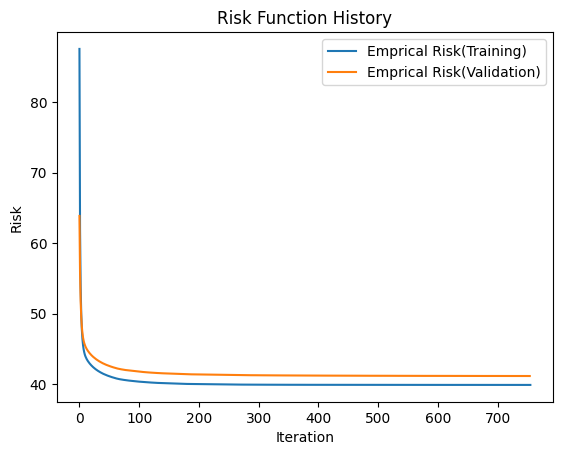

-0.5120*X1^4 + 0.0550*X1^3 + -2.8632*X1^2 + 0.0030*X1^1 + -0.5120*X2^4 + -2.8632*X2^3 + 1.0496*X2^2 + 0.2726*X2^1 + 0.0550 = y1'
0.0026*X1^4 + -4.0266*X1^3 + 0.0017*X1^2 + 5.0609*X1^1 + 0.0026*X2^4 + 0.0017*X2^3 + -1.0519*X2^2 + -0.6272*X2^1 + -4.0266 = y2'
-0.4614*X1^4 + 0.8142*X1^3 + -2.1361*X1^2 + -3.8336*X1^1 + -0.4614*X2^4 + -2.1361*X2^3 + 0.8097*X2^2 + 0.0053*X2^1 + 0.8142 = y3'
['p<0.05', 'p>0.05', 'p<0.001', 'p>0.05', 'p<0.001', 'p<0.001', 'p>0.05', 'p>0.05']
['p>0.05', 'p<0.001', 'p>0.05', 'p<0.001', 'p<0.001', 'p>0.05', 'p>0.05', 'p<0.001']
['p<0.01', 'p<0.001', 'p<0.001', 'p<0.001', 'p<0.001', 'p<0.001', 'p>0.05', 'p>0.05']


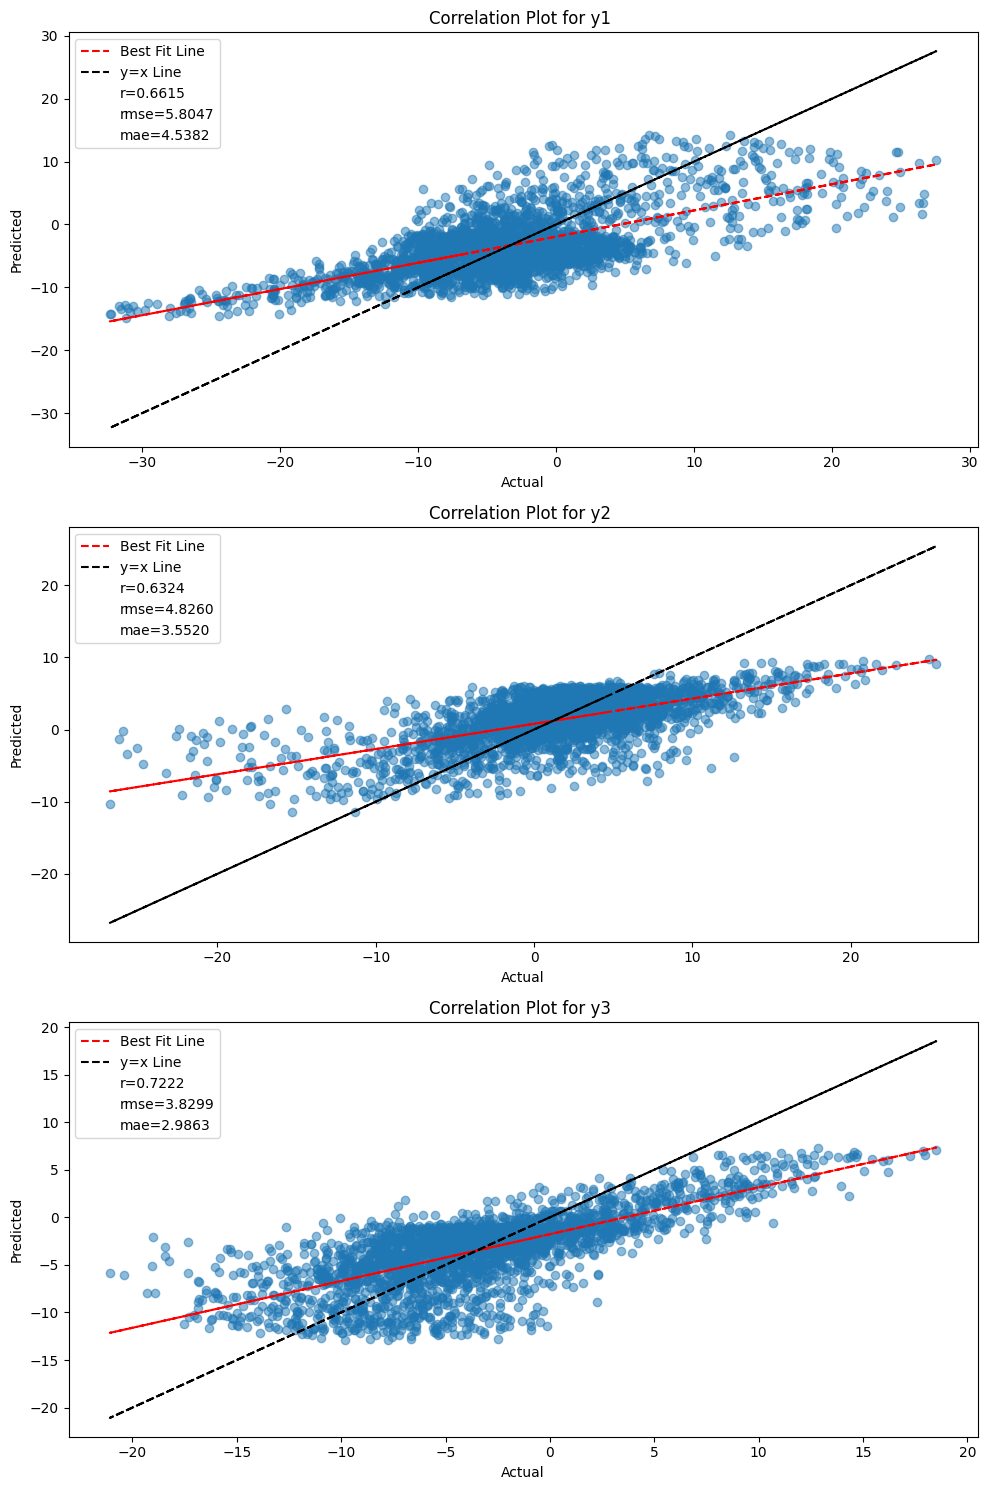

In [55]:
theta_gd_quad_reg_l1, train_losses, val_losses = grad_desc_sq_err_reg_L1(
    X_train, y_train, X_val, y_val, 2)
plot_train_loss(train_losses, val_losses)
print_poly(theta_gd_quad_reg_l1, 2)
plot_y(X_test, y_test, theta_gd_quad_reg_l1, 2)


theta_gd_cub_reg_l1, train_losses, val_losses = grad_desc_sq_err_reg_L1(
    X_train, y_train, X_val, y_val, 3)
plot_train_loss(train_losses, val_losses)
print_poly(theta_gd_cub_reg_l1, 3)
plot_y(X_test, y_test, theta_gd_cub_reg_l1, 3)


theta_gd_biquad_reg_l1, train_losses, val_losses = grad_desc_sq_err_reg_L1(
    X_train, y_train, X_val, y_val, 4)
plot_train_loss(train_losses, val_losses)
print_poly(theta_gd_biquad_reg_l1, 4)
plot_y(X_test, y_test, theta_gd_biquad_reg_l1, 4)